<h1 style="font-size:2rem; color:blue;"> Snow climatology using the ESA CCI Viewable snow product level L3C daily from AVHRR over the period 1982-2019 in the Mediterranean area without imputation of missing data </h1>

<h1 style="font-size:1.2rem; color:black;"> In this notebook, we will first explore the snow fraction data from the ESA CCI product. Then, we will make monthly, seasonal, and annual climatologies over the whole period 1982-2019.  </h1>   

## 1. Importing python moduls 

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import os 
import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import datetime as dt
import calendar as cld
import matplotlib.pyplot as plt
import xarray as xr
from os import listdir
from os.path import isfile, join
import cartopy.crs as ccrs
import cartopy 
import proplot as plot  # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import sys
import pymannkendall as mk
import calendar
import time

#import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
sys.path.insert(1, '/home/hamid/Desktop/results/') # to include my util file in previous directory

# ============================================================================
# Models for parallelisation
import multiprocessing 
from dask.distributed import Client
from dask import delayed
from dask import compute
# client = Client(n_workers=4, threads_per_worker=3, memory_limit='4GB')
client = Client(n_workers=16, threads_per_worker=1, memory_limit='2GB')
# client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41191,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:35355,Total threads: 1
Dashboard: http://127.0.0.1:41981/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:44383,


In [2]:
client.close()

## 2. Check and import data 

In [3]:
# Path to data
path_snow_CCI = '/home/hamid/dap.ceda.ac.uk/neodc/esacci/snow/data/scfv/AVHRR_MERGED/v2.0/Atlas_scfv'
month = ["01","02","03","04","05","06","07","08","09","10","11","12"]
startyear = 1982
endyear = 2018
period = endyear - startyear + 1

ds0 = xr.open_mfdataset(path_snow_CCI+'/'+str(startyear)+'/01/*.nc')
for m in month[2:12]:
    aux = xr.open_mfdataset(path_snow_CCI+'/'+str(startyear)+'/'+m+'/*.nc')
    ds0=xr.concat([ds0, aux], dim='time')
print(str(startyear)+" scfv data is imported")
ds = ds0
year =startyear+1
#for year in range(startyear+1, endyear+1):
# !!! We have used an if condition to allow the 
# loop to skip the last two months of 1994, as no data is available 
while year < endyear+1:
    for m in month:
        if year == 1994 and m =="11":
            year=1995
        aux = xr.open_mfdataset(path_snow_CCI+'/'+str(year)+'/'+m+'/*.nc', parallel = True)
        ds=xr.concat([ds, aux], dim='time')
    print(str(year)+" scfv data is imported")
    year=year+1
print(ds)
print("==================================================================================")
ds  

1982 scfv data is imported
1983 scfv data is imported
1984 scfv data is imported
1985 scfv data is imported
1986 scfv data is imported
1987 scfv data is imported
1988 scfv data is imported
1989 scfv data is imported
1990 scfv data is imported
1991 scfv data is imported
1992 scfv data is imported
1993 scfv data is imported
1995 scfv data is imported
1996 scfv data is imported
1997 scfv data is imported
1998 scfv data is imported
1999 scfv data is imported
2000 scfv data is imported
2001 scfv data is imported
2002 scfv data is imported
2003 scfv data is imported
2004 scfv data is imported
2005 scfv data is imported
2006 scfv data is imported
2007 scfv data is imported
2008 scfv data is imported
2009 scfv data is imported


/home/hamid/anaconda3/envs/my_env/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home/hamid/anaconda3/envs/my_env/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
 

2010 scfv data is imported
2011 scfv data is imported
2012 scfv data is imported
2013 scfv data is imported
2014 scfv data is imported
2015 scfv data is imported
2016 scfv data is imported
2017 scfv data is imported
2018 scfv data is imported
<xarray.Dataset>
Dimensions:   (lon: 400, lat: 320, time: 13093, bnds: 2)
Coordinates:
  * lon       (lon) float64 -9.975 -9.975 -9.925 ... -0.075 -0.02501 -0.025
  * lat       (lat) float64 28.02 28.02 28.07 28.08 ... 35.92 35.92 35.97 35.97
  * time      (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2018-12-30
Dimensions without coordinates: bnds
Data variables:
    lon_bnds  (time, lon, bnds) float64 dask.array<chunksize=(1, 400, 2), meta=np.ndarray>
    lat_bnds  (time, lat, bnds) float64 dask.array<chunksize=(1, 320, 2), meta=np.ndarray>
    scfv      (time, lat, lon) float32 dask.array<chunksize=(1, 320, 400), meta=np.ndarray>
    scfv_unc  (time, lat, lon) float32 dask.array<chunksize=(1, 320, 400), meta=np.ndarray>
Attributes: (12/44)
  

<xarray.Dataset>
Dimensions:   (lon: 400, lat: 320, time: 13093, bnds: 2)
Coordinates:
  * lon       (lon) float64 -9.975 -9.975 -9.925 ... -0.075 -0.02501 -0.025
  * lat       (lat) float64 28.02 28.02 28.07 28.08 ... 35.92 35.92 35.97 35.97
  * time      (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2018-12-30
Dimensions without coordinates: bnds
Data variables:
    lon_bnds  (time, lon, bnds) float64 dask.array<chunksize=(1, 400, 2), meta=np.ndarray>
    lat_bnds  (time, lat, bnds) float64 dask.array<chunksize=(1, 320, 2), meta=np.ndarray>
    scfv      (time, lat, lon) float32 dask.array<chunksize=(1, 320, 400), meta=np.ndarray>
    scfv_unc  (time, lat, lon) float32 dask.array<chunksize=(1, 320, 400), meta=np.ndarray>
Attributes: (12/44)
    CDI:                        Climate Data Interface version 1.9.9rc1 (http...
    Conventions:                CF-1.9
    history:                    Sun May 22 15:43:21 2022: cdo sellonlatbox,-1...
    source:                     AVHRR_NOAA-7_GAC mosaic from ESA Cloud CCI pr...
    institution:                Remote Sensing Research Group, Institute of G...
    title:                      ESA CCI viewable snow product level L3C daily...
    ...                         ...
    platform:                   NOAA-7
    sensor:                     AVHRR
    spatial_resolution:         0.05 degree
    key_variables:              scfv
    doi:                        10.5285/763eb87e0682446cafa8c74488dd5fb8
    CDO:                        Climate Data Operators version 1.9.9rc1 (http...

<h1 style="font-size:1.2rem; color:black;"> Define the weight of the leap years in our period  </h1> 

In [4]:
sum = 0
for year in range(startyear, endyear+1):
    if calendar.isleap(year):
        sum = sum+1
    else:
        sum = sum
weight = sum / (endyear - startyear +1)
print("the weight of leap years in our period is " + str(np.round(weight,3)))

the weight of leap years in our period is 0.243


<h1 style="font-size:1.2rem; color:black;"> Select variable (scfv in our case)  </h1>  

In [5]:
scfv = ds['scfv']
print("======================== scfv ============================")
scfv

======================== scfv ============================


<xarray.DataArray 'scfv' (time: 13093, lat: 320, lon: 400)>
dask.array<concatenate, shape=(13093, 320, 400), dtype=float32, chunksize=(1, 320, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -9.975 -9.975 -9.925 ... -0.075 -0.02501 -0.025
  * lat      (lat) float64 28.02 28.02 28.07 28.08 ... 35.92 35.92 35.97 35.97
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2018-12-30
Attributes:
    standard_name:        snow_area_fraction_viewable_from_above
    long_name:            Snow Cover Fraction Viewable
    units:                percent
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    ancillary_variables:  scfv_unc

<h1 style="font-size:1.2rem; color:black;"> Store scfv_subset in netcdf files in the hard disk </h1>

In [7]:
# Directory
directory = "intermediate_files"
  
# Parent Directory path
parent_dir = "/home/hamid/Desktop/"
  
# Path
path = os.path.join(parent_dir, directory)
 
# Create the directory in '/home / User / Desktop'
os.mkdir(path)
print("Directory '% s' created" % directory)

Directory 'intermediate_files' created


In [8]:
scfv_atlas = scfv

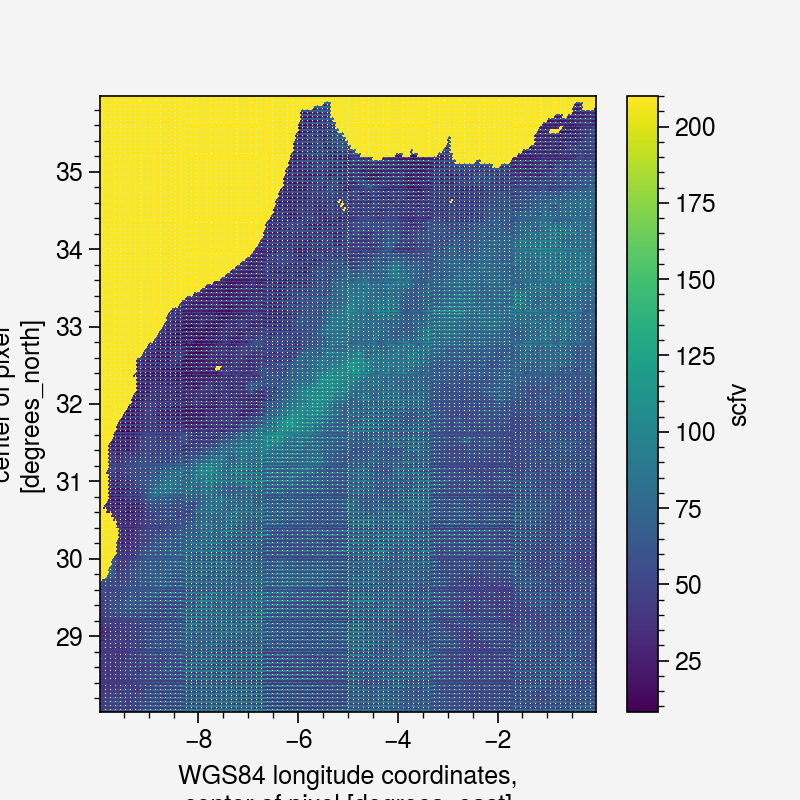

In [9]:
aux = scfv_atlas.mean(dim = 'time')
aux.plot()

<h1 style="font-size:1.2rem; color:black;"> We create another dataset that contains only the values between 0 and 100% of scfv </h1>

In [10]:
scfv_atlas_filtred = scfv_atlas.where(scfv_atlas <= 100)

In [11]:
scfv_atlas_filtred

<xarray.DataArray 'scfv' (time: 13093, lat: 320, lon: 400)>
dask.array<where, shape=(13093, 320, 400), dtype=float32, chunksize=(1, 320, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -9.975 -9.975 -9.925 ... -0.075 -0.02501 -0.025
  * lat      (lat) float64 28.02 28.02 28.07 28.08 ... 35.92 35.92 35.97 35.97
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2018-12-30
Attributes:
    standard_name:        snow_area_fraction_viewable_from_above
    long_name:            Snow Cover Fraction Viewable
    units:                percent
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    ancillary_variables:  scfv_unc

<h1 style="font-size:1.2rem; color:black;"> Store scfv_atlas_filtred in netcdf files in the hard disk </h1>

In [12]:
scfv_atlas_filtred.to_netcdf(path + "/scfv_atlas_filtred.nc")

<h1 style="font-size:1.2rem; color:black;"> Quick viewing of mean in time </h1>

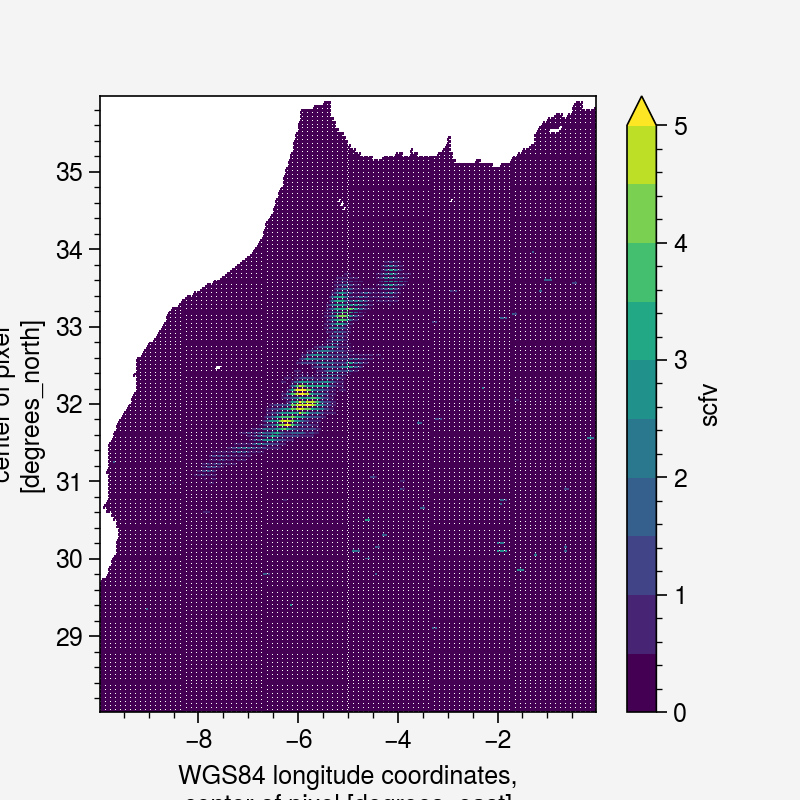

In [13]:
scfv_atlas_filtred.mean(dim='time').plot(levels=plot.arange(0, 5,0.5))

## 3. Data coverage

In [14]:
aux = scfv_atlas_filtred.count(dim='time')
aux.values 

array([[   45,     0,    48, ...,     0,    36,     0],
       [    0, 10414,     0, ..., 10406,     0, 10389],
       [   49,     0,    51, ...,     0,    37,     0],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]])

<xarray.DataArray 'Data coverage' (lat: 320, lon: 400)>
dask.array<mul, shape=(320, 400), dtype=float64, chunksize=(320, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -9.975 -9.975 -9.925 ... -0.075 -0.02501 -0.025
  * lat      (lat) float64 28.02 28.02 28.07 28.08 ... 35.92 35.92 35.97 35.97
Attributes:
    units:    %


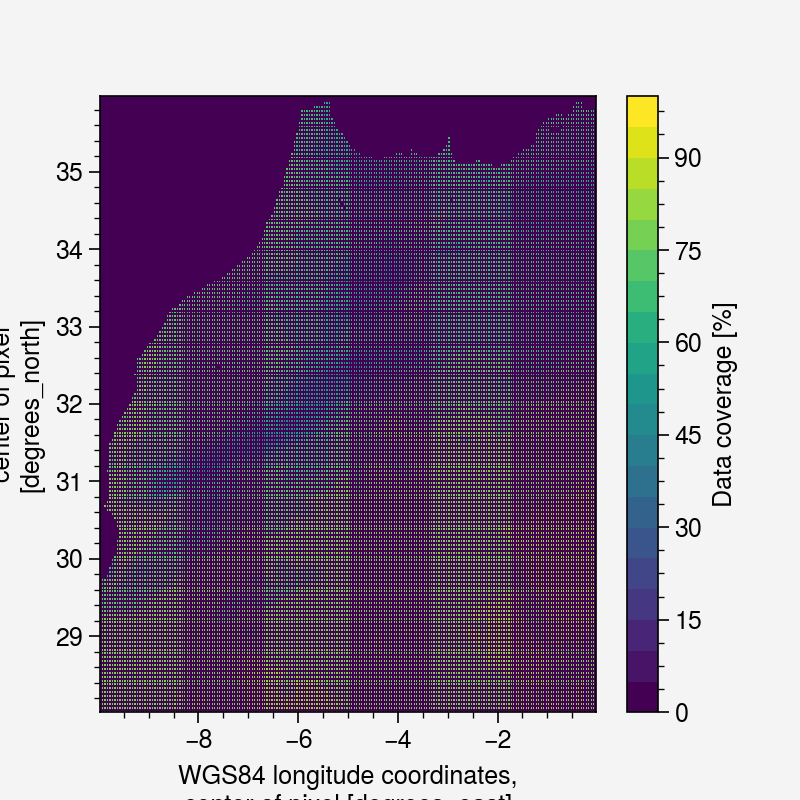

In [15]:
data_coverage = ((scfv_atlas_filtred.count(dim='time') / scfv_atlas.time.size)*100)
data_coverage.name = 'Data coverage'
data_coverage.attrs['units'] = '%'

print(data_coverage)

data_coverage.plot(levels=plot.arange(0, 100, 5))

<h1 style="font-size:1.2rem; color:black;"> Store data_coverage in netcdf files in the hard disk </h1>

In [ ]:
data_coverage.to_netcdf(path + "/data_covered_atlas.nc")

<h1 style="font-size:1.2rem; color:black;"> Percentage of covered data in each month over the hole periode (1982-2018)  </h1>

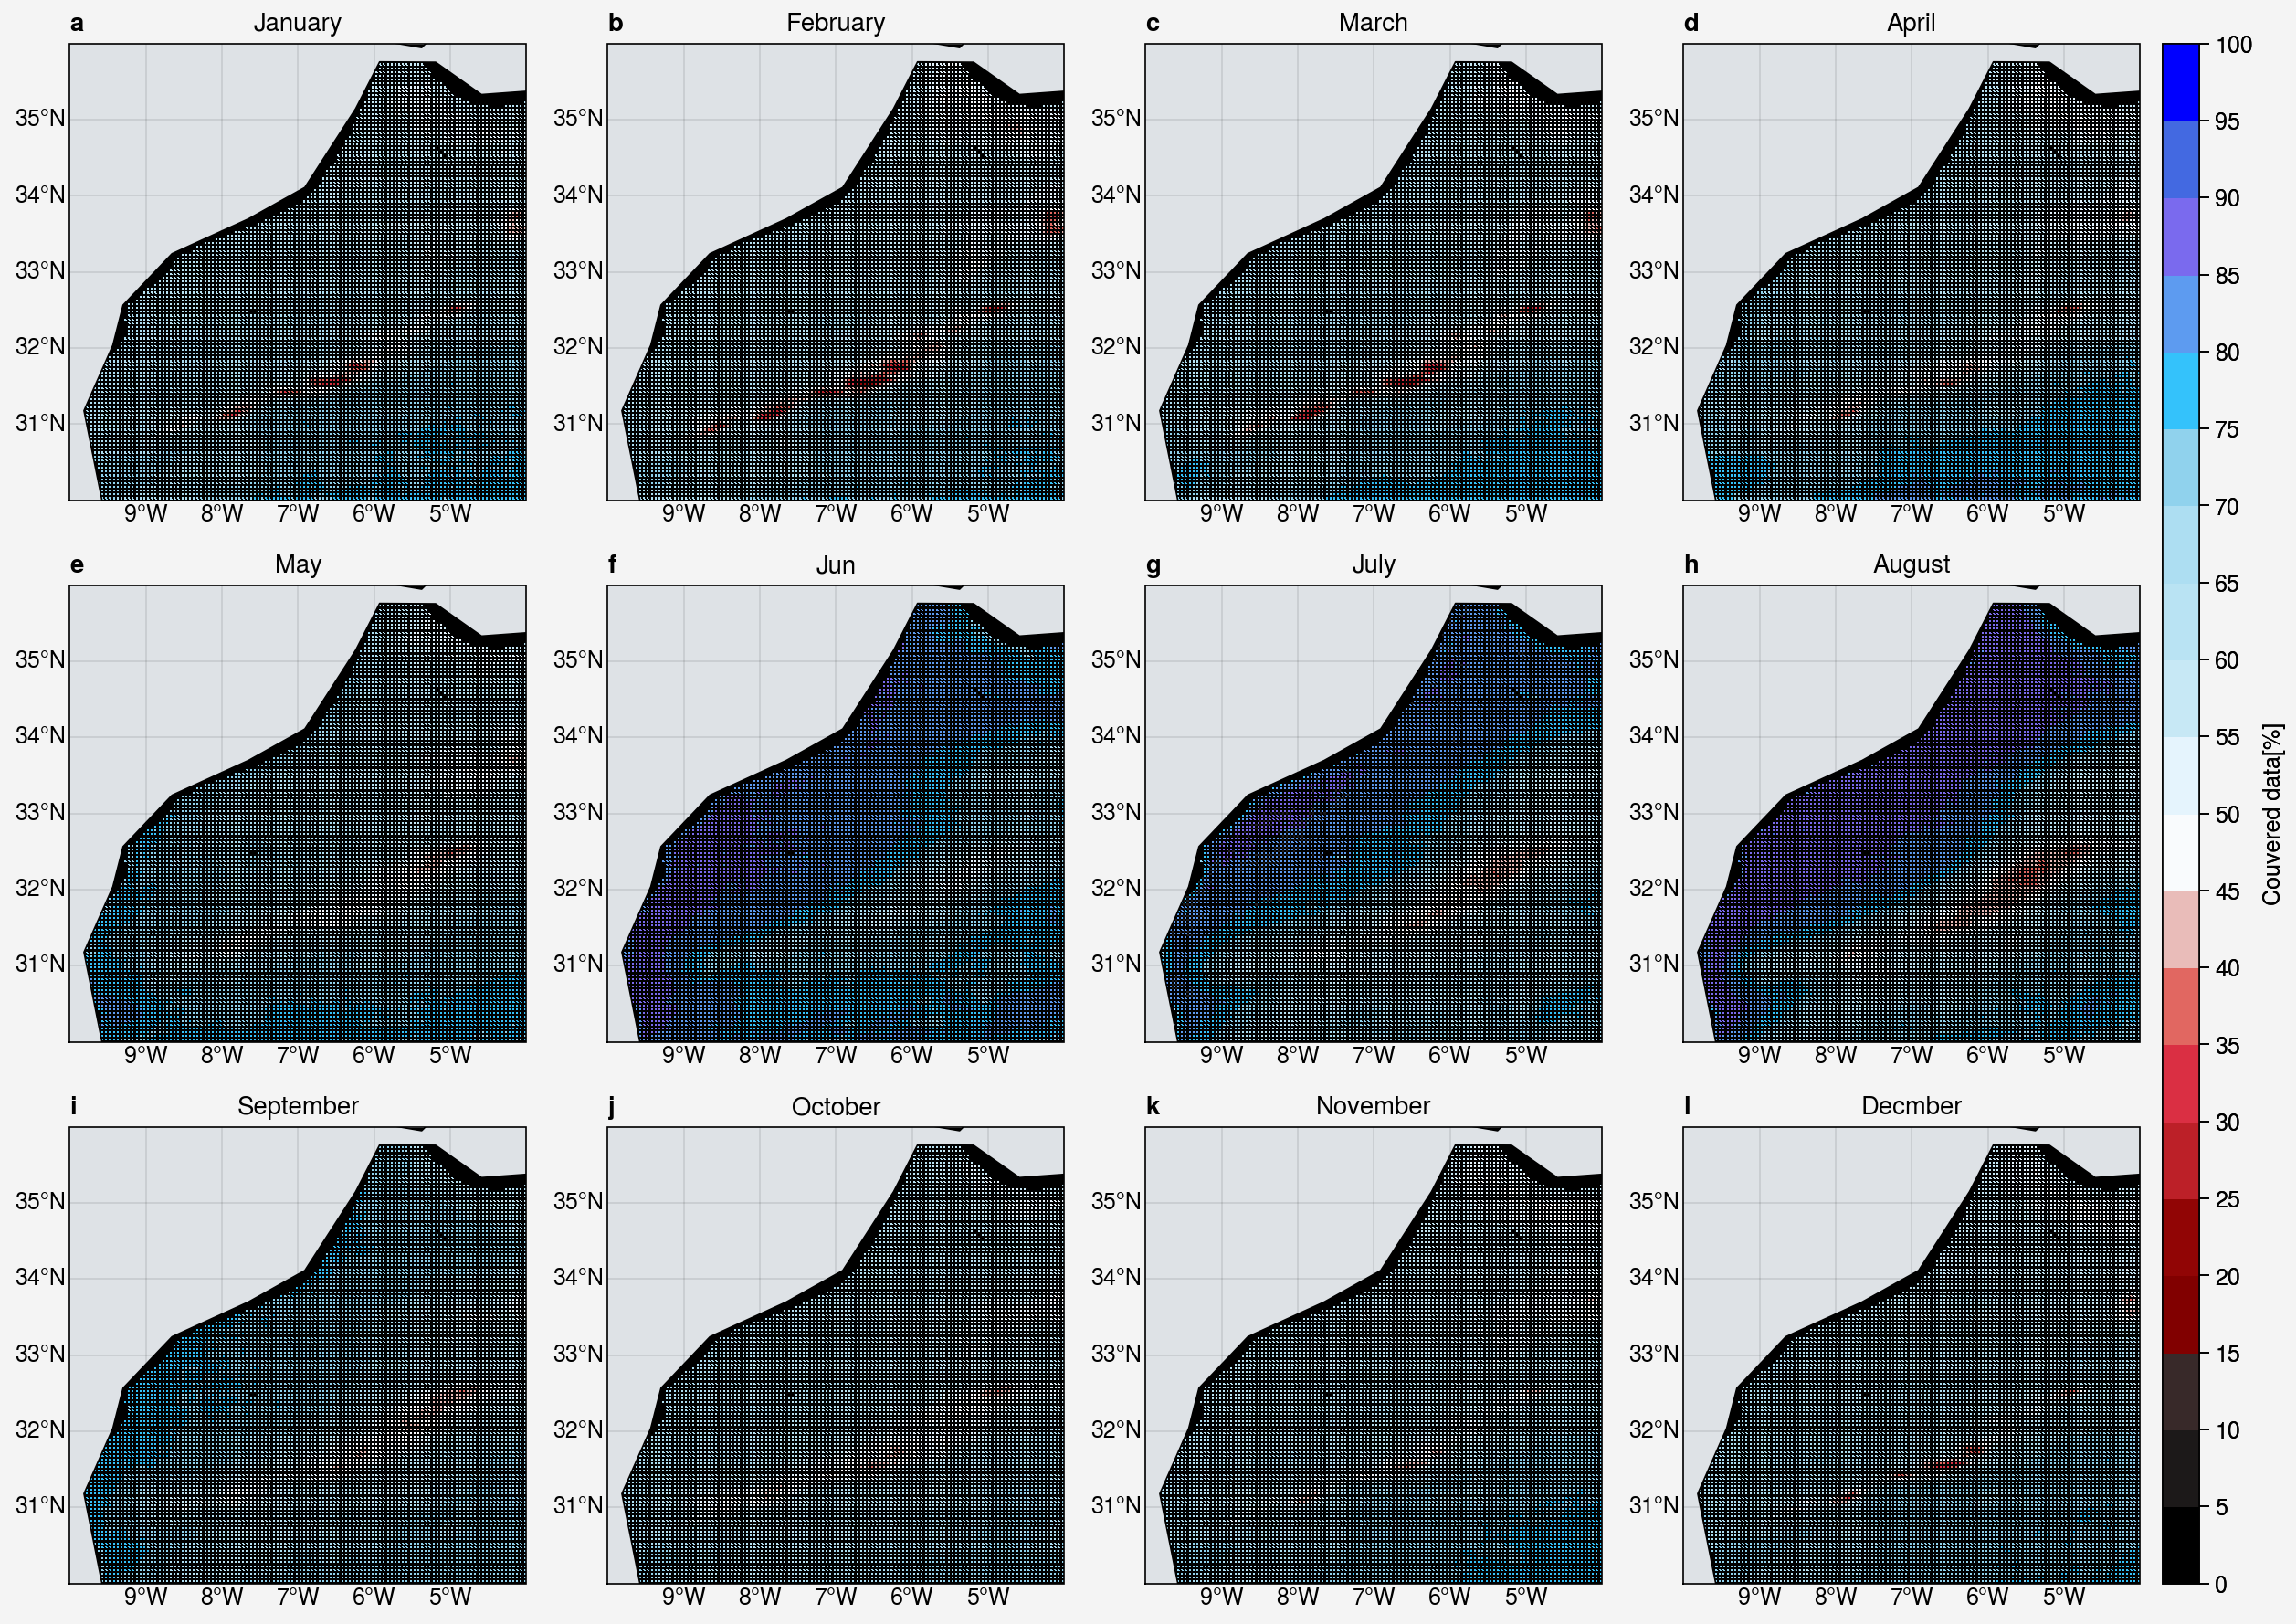

In [17]:
time_period = period                               
m1 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==1).count('time') / (31*time_period))*100).load()
m2 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==2).count('time') / ((28+weight)*time_period))*100).load()
m3 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==3).count('time') / (31*time_period))*100).load()
m4 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==4).count('time') / (30*time_period))*100).load()
m5 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==5).count('time') / (31*time_period))*100).load()
m6 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==6).count('time') / (30*time_period))*100).load()
m7 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==7).count('time') / (31*time_period))*100).load()
m8 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==8).count('time') / (31*time_period))*100).load()
m9 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==9).count('time') / (30*time_period))*100).load()
m10 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==10).count('time') / (31*time_period))*100).load()
m11 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==11).count('time') / (30*time_period))*100).load()
m12 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==12).count('time') / (31*time_period))*100).load()


cmap=[ "#000000", "#1C1919", "#352929","#800000","#8B0000", "#B22222",  "#DC143C","#CD5C5C","#FA8072", "#FFFFFF",  
      "#F0F8FF", "#dbf0f9","#b9e3f3","#b9e3f3", "#a9dcf1", "#87ceeb","#00BFFF","#6495ED","#7B68EE", "#4169E1", "#0000FF"]
#levels=[0, 5, 10, 15,20, 25, 30, 35, 40, 45,50 ,55 , 60,65,70,75, 80,85,90,95, 100]
levels=[0,5,10,15,20,25, 30,35,40,45,50,55, 60,65, 70,75,80,85, 90,95, 100]            
var_label = 'Couvered data[%]'
f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3)

mon = {1: "January", 2:"February", 3:"March", 4:"April", 5: "May", 6:"Jun", 7:"July", 8:"August", 9:"September",10:"October", 11:"November", 12:"Decmber"}   
var = {1: m1, 2:m2, 3:m3, 4:m4, 5: m5, 6:m6, 7:m7, 8:m8, 9:m9,10:m10, 11:m11, 12:m12}    
for i, ax in enumerate(axs):
    m = ax.pcolormesh(  
        var[i+1], 
        cmap=cmap,
        levels=levels,
        extend='neither'
        )
    ax.format(title=mon[i+1])
    
f.colorbar(m, label=var_label)    
axs.format(
    labels=True,                    
    coast=True, ocean=True, oceancolor='gray3', borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()


<h1 style="font-size:1.2rem; color:black;"> Percentage of masked pixels by clouds in each month over the hole periode (1982-2018)  </h1>

In [18]:
clouds_percentage = scfv_atlas.where(scfv_atlas == 205)

In [19]:
clouds_percentage

<xarray.DataArray 'scfv' (time: 13093, lat: 320, lon: 400)>
dask.array<where, shape=(13093, 320, 400), dtype=float32, chunksize=(1, 320, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -9.975 -9.975 -9.925 ... -0.075 -0.02501 -0.025
  * lat      (lat) float64 28.02 28.02 28.07 28.08 ... 35.92 35.92 35.97 35.97
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2018-12-30
Attributes:
    standard_name:        snow_area_fraction_viewable_from_above
    long_name:            Snow Cover Fraction Viewable
    units:                percent
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    ancillary_variables:  scfv_unc

In [20]:
clouds_percentage.to_netcdf(path + "/clouds_percentage.nc")

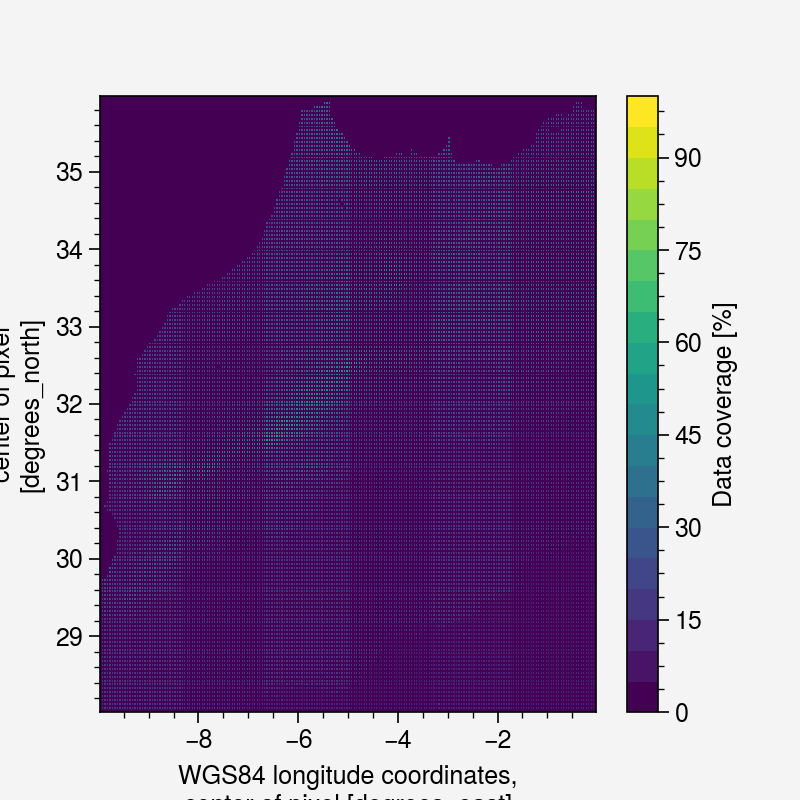

In [21]:
cloud_mask = ((clouds_percentage.count(dim='time') / scfv_atlas.time.size)*100)
cloud_mask.name = 'Data coverage'
cloud_mask.attrs['units'] = '%'

cloud_mask

cloud_mask.plot(levels=plot.arange(0, 100, 5))

<h1 style="font-size:1.2rem; color:black;"> Store cloud_mask in netcdf files in the hard disk </h1>

In [ ]:
cloud_mask.to_netcdf(path + "/cloud_mask_atlas.nc")

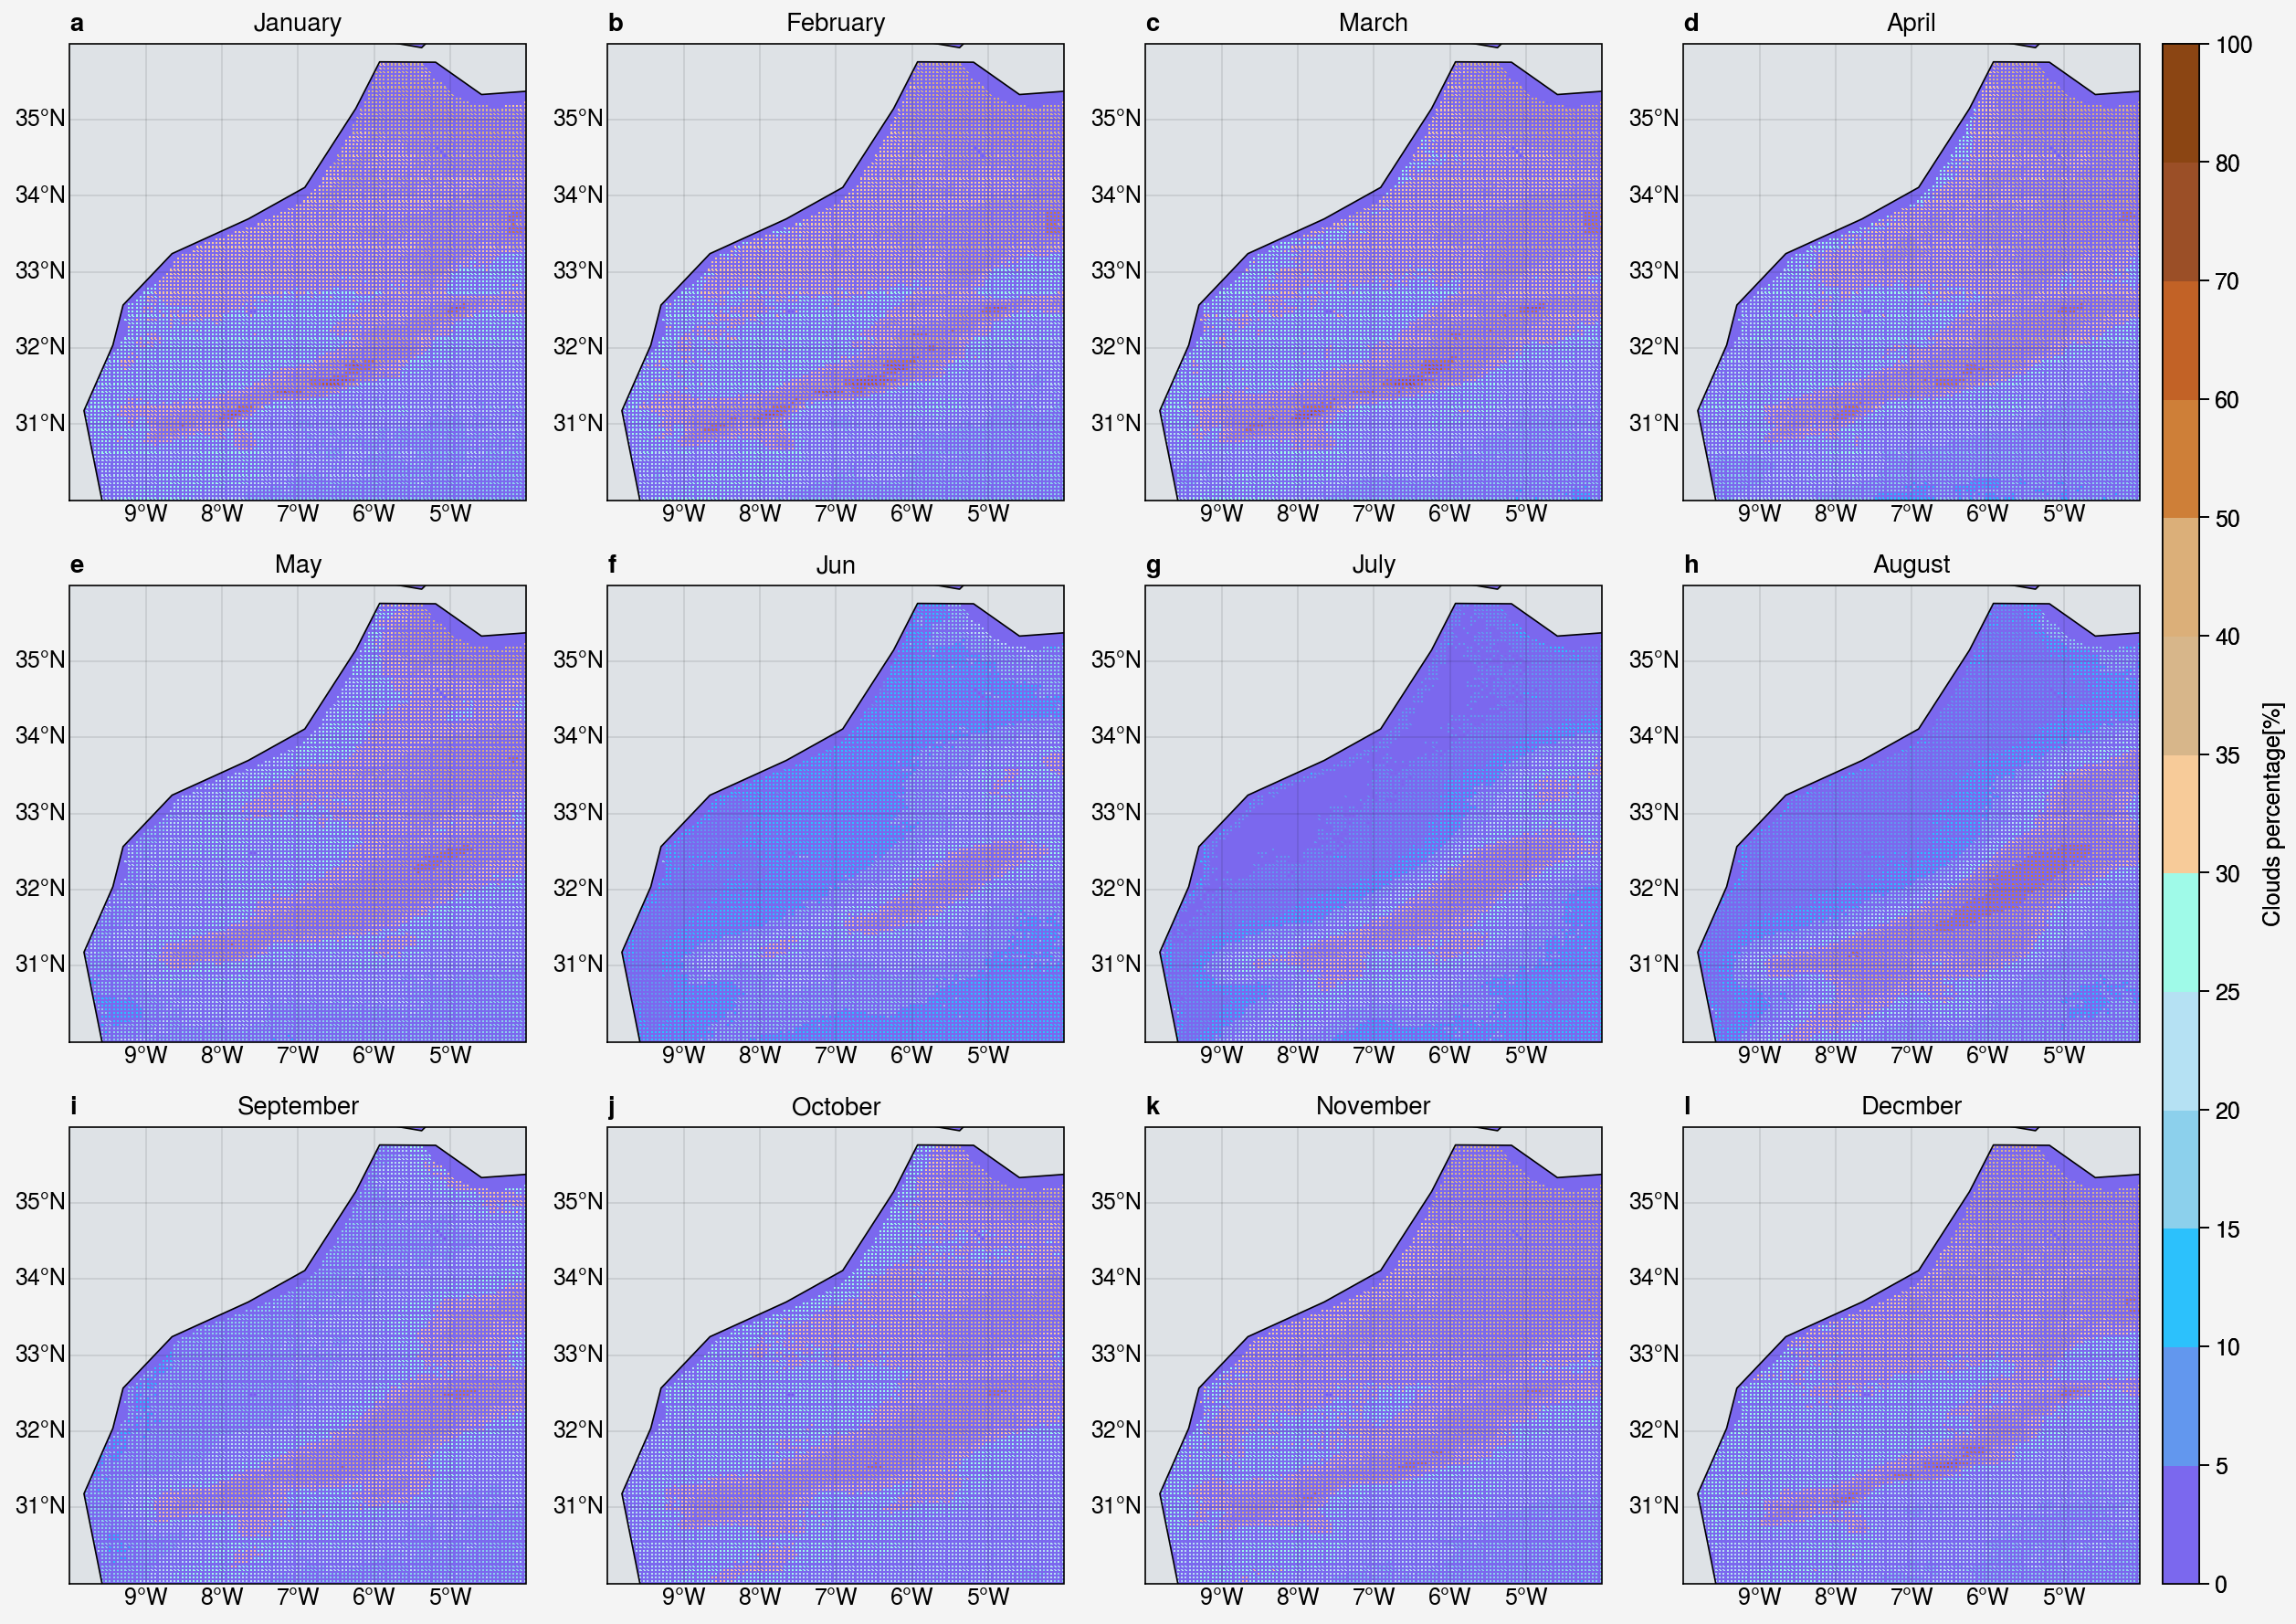

In [22]:
time_period = period   

m1 = ((clouds_percentage.where(clouds_percentage['time.month']==1).count('time') / (31*time_period))*100).load()
m2 = ((clouds_percentage.where(clouds_percentage['time.month']==2).count('time') / ((28+weight)*time_period))*100).load()
m3 = ((clouds_percentage.where(clouds_percentage['time.month']==3).count('time') / (31*time_period))*100).load()
m4 = ((clouds_percentage.where(clouds_percentage['time.month']==4).count('time') / (30*time_period))*100).load()
m5 = ((clouds_percentage.where(clouds_percentage['time.month']==5).count('time') / (31*time_period))*100).load()
m6 = ((clouds_percentage.where(clouds_percentage['time.month']==6).count('time') / (30*time_period))*100).load()
m7 = ((clouds_percentage.where(clouds_percentage['time.month']==7).count('time') / (31*time_period))*100).load()
m8 = ((clouds_percentage.where(clouds_percentage['time.month']==8).count('time') / (31*time_period))*100).load()
m9 = ((clouds_percentage.where(clouds_percentage['time.month']==9).count('time') / (30*time_period))*100).load()
m10 = ((clouds_percentage.where(clouds_percentage['time.month']==10).count('time') / (31*time_period))*100).load()
m11 = ((clouds_percentage.where(clouds_percentage['time.month']==11).count('time') / (30*time_period))*100).load()
m12 = ((clouds_percentage.where(clouds_percentage['time.month']==12).count('time') / (31*time_period))*100).load()


cmap=["#7B68EE", "#6495ED", "#00BFFF","#87ceeb", "#a9dcf1", "#dbf0f9",
      "#FFDAB9", "#D2B48C", "#DEB887", "#CD853F", "#D2691E", "#A0522D", "#8B4513" ]
#levels=[0, 5, 10, 15, 20, 25, 30, 35, 40,50,60,70,80,100]
levels=[0, 5, 10, 15, 20, 25, 30, 35, 40,50,60,70,80,100]            
var_label = 'Clouds percentage[%]'
f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3)

mon = {1: "January", 2:"February", 3:"March", 4:"April", 5: "May", 6:"Jun", 7:"July", 8:"August", 9:"September",10:"October", 11:"November", 12:"Decmber"}   
var = {1: m1, 2:m2, 3:m3, 4:m4, 5: m5, 6:m6, 7:m7, 8:m8, 9:m9,10:m10, 11:m11, 12:m12}    
for i, ax in enumerate(axs):
    m = ax.pcolormesh(  
        var[i+1], 
        cmap=cmap,
        levels=levels,
        extend='neither'
        )
    ax.format(title=mon[i+1])
    
f.colorbar(m, label=var_label)    
axs.format(
    labels=True,                    
    coast=True, ocean=True, oceancolor='gray3', borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()


## 4. Monthly, seasonal and yearly averages over the period 1982-2018

<h1 style="font-size:1.2rem; color:black;"> Monthly average computing </h1> 

In [23]:
monthly_mean = scfv_atlas_filtred.groupby('time.month').mean(dim='time')

In [24]:
monthly_mean

<xarray.DataArray 'scfv' (month: 12, lat: 320, lon: 400)>
dask.array<stack, shape=(12, 320, 400), dtype=float32, chunksize=(1, 320, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -9.975 -9.975 -9.925 ... -0.075 -0.02501 -0.025
  * lat      (lat) float64 28.02 28.02 28.07 28.08 ... 35.92 35.92 35.97 35.97
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

<h1 style="font-size:1.2rem; color:black;"> Store monthly_mean in netcdf files in the hard disk </h1>

In [ ]:
monthly_mean.to_netcdf(path + "/monthly_mean.nc")

<h1 style="font-size:1.2rem; color:black;"> Monthly average plot </h1>

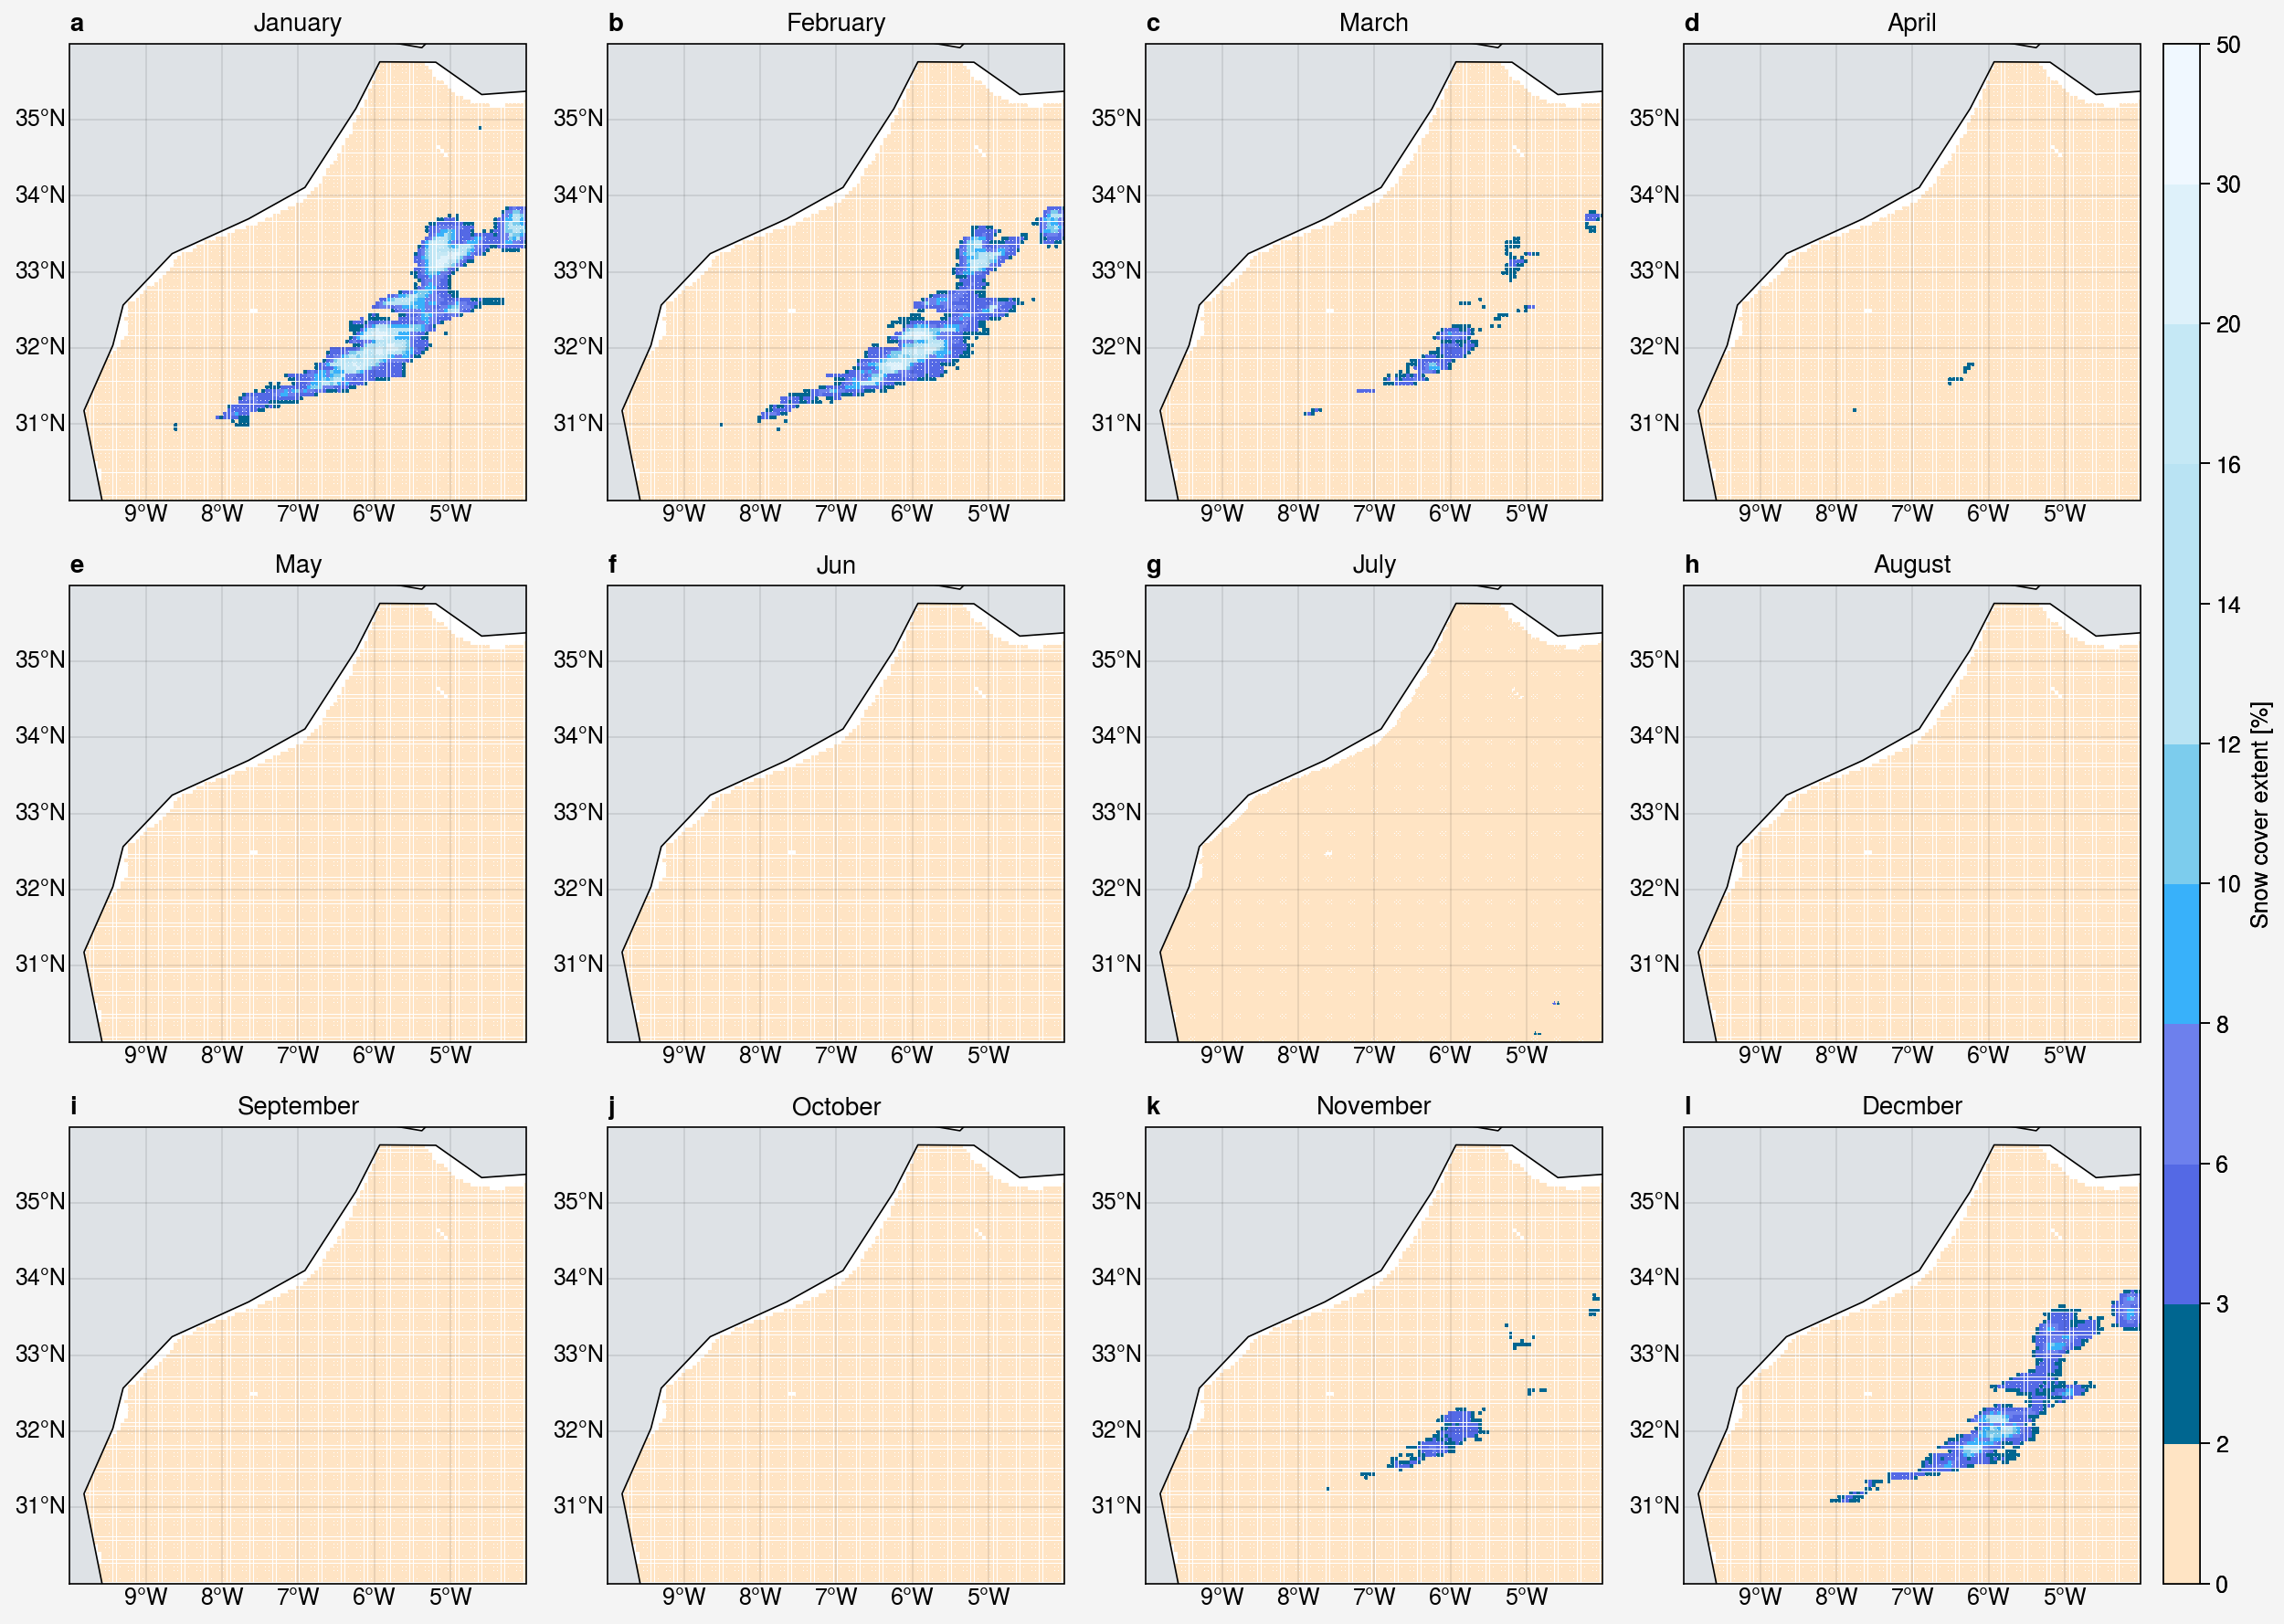

In [25]:
aux = monthly_mean

cmap=["bisque","#0000FF","#4169E1","#7B68EE","#6495ED","#00BFFF","#87ceeb","#b9e3f3","#b9e3f3","#dbf0f9",
"#F0F8FF"]
levels=[0, 2, 3, 6,8,10,12,14,16,20,30,50]          
var_label = 'Snow cover extent [%]'

f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3)

dic = {1: "January", 2:"February", 3:"March", 4:"April", 5: "May", 6:"Jun", 7:"July", 8:"August", 9:"September",10:"October", 11:"November", 12:"Decmber"}   
for i, ax in enumerate(axs):
    m = ax.pcolormesh(  
        aux[i,:,:], 
        cmap=cmap,
        levels=levels,
        extend='neither'
        )
    ax.format(title=dic[i+1])
    
f.colorbar(m, label=var_label)

axs.format(  
    labels=True,                    
    coast=True, ocean=True, oceancolor='gray3', borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()

<h1 style="font-size:1.2rem; color:black;"> Seasonal average computing </h1>  

In [26]:
seasonal_mean = scfv_atlas_filtred.groupby('time.season').mean(dim='time')

In [27]:
seasonal_mean

<xarray.DataArray 'scfv' (season: 4, lat: 320, lon: 400)>
dask.array<stack, shape=(4, 320, 400), dtype=float32, chunksize=(1, 320, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -9.975 -9.975 -9.925 ... -0.075 -0.02501 -0.025
  * lat      (lat) float64 28.02 28.02 28.07 28.08 ... 35.92 35.92 35.97 35.97
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

<h1 style="font-size:1.2rem; color:black;"> Seasonal average plot </h1>  

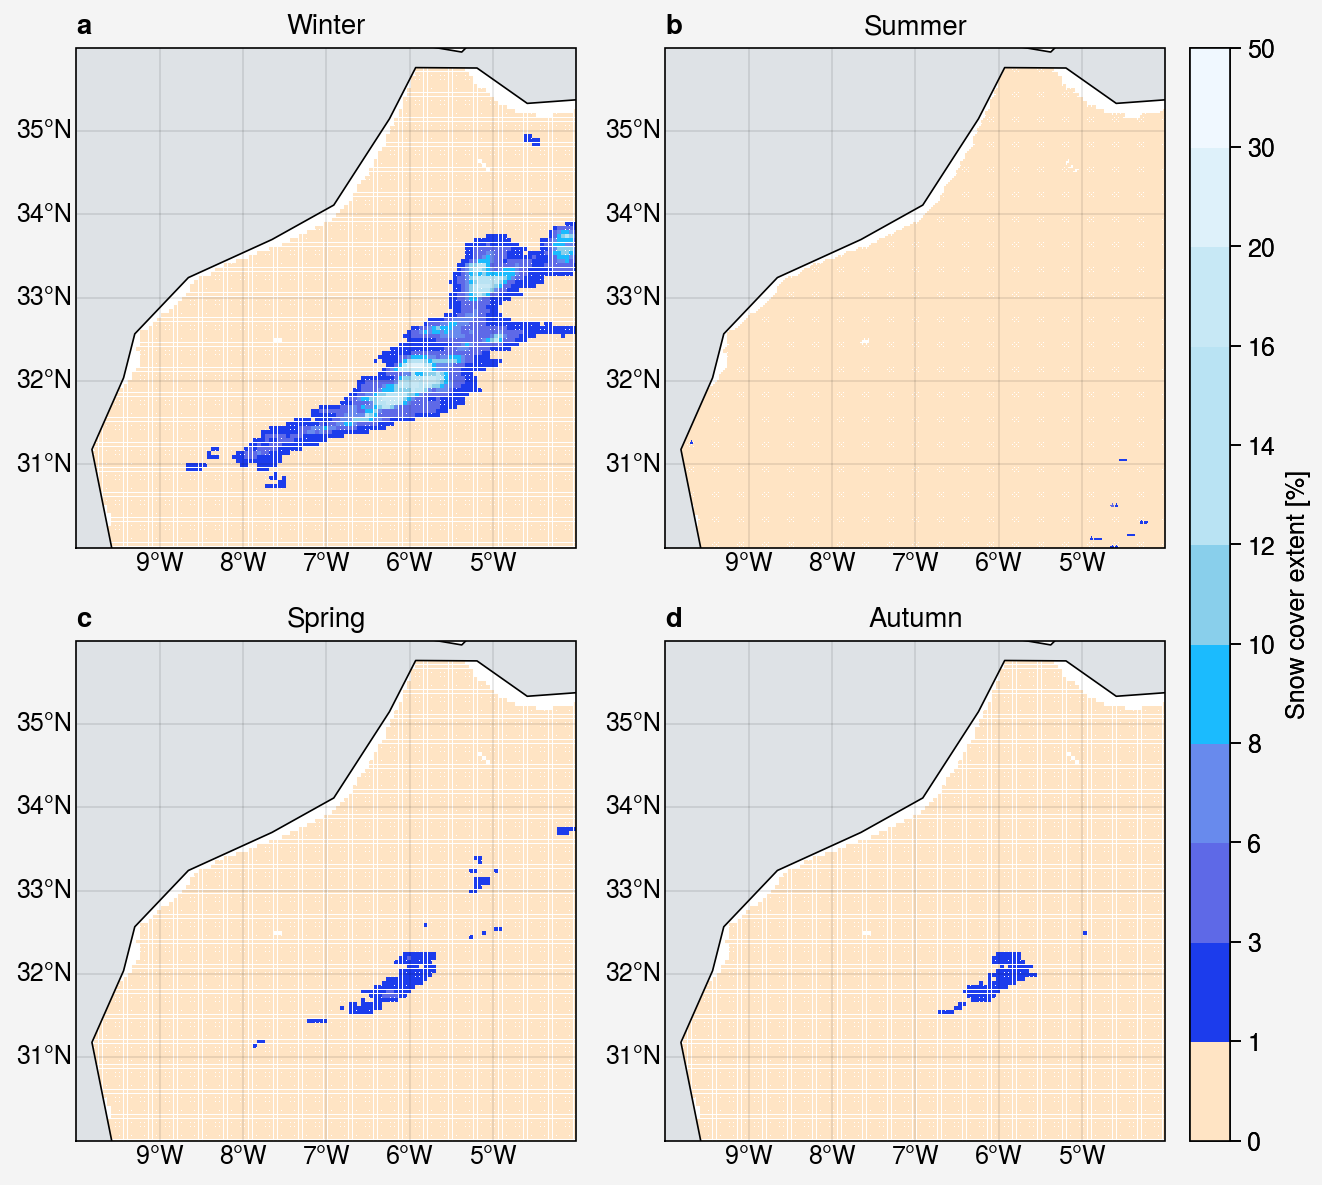

In [29]:
aux = seasonal_mean

cmap=["bisque","#0000FF","#4169E1","#7B68EE","#6495ED","#00BFFF","#87ceeb","#b9e3f3","#b9e3f3","#dbf0f9",
"#F0F8FF"]
levels=[0, 1, 3, 6,8,10,12,14,16,20,30,50]          
var_label = 'Snow cover extent [%]'

f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2)

dic = {1: "Winter", 2:"Summer", 3:"Spring", 4:"Autumn"}   
for i, ax in enumerate(axs):
    m = ax.pcolormesh(  
        aux[i,:,:], 
        cmap=cmap,
        levels=levels,
        extend='neither'
        )
    ax.format(title=dic[i+1])
    
f.colorbar(m, label=var_label)

axs.format(          
    labels=True,                    
    coast=True, ocean=True, oceancolor='gray3', borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()


<h1 style="font-size:1.2rem; color:black;"> Yearly average plot </h1>  

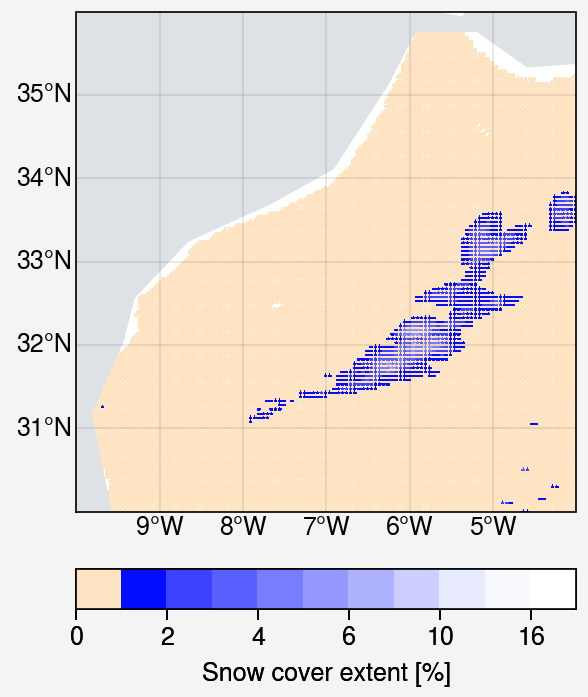

In [30]:
#ds = ds.sel(time=slice("1982-02-01","2019-12-31"))
aux = scfv_atlas_filtred.mean(dim='time')

cmap=["bisque","#0009FF", "#3940FF", "#575CFF", "#7378FF", "#9093FF","#ACAFFF", "#C9CAFF","#E5E6FF","#F7F9FF", "#FFFFFF"]
levels=[0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20]          
var_label = 'Snow cover extent [%]'

f, ax = plot.subplots(proj='cyl', ncols=1, nrows=1)

m = ax.pcolormesh(aux, cmap=cmap, levels=levels, extend='neither')
ax.format(title="")
    
f.colorbar(m, label=var_label, orientation='horizontal', location='bottom')

ax.format(
    labels=True,                    
    coast=False, ocean=True, oceancolor='gray3', borders=False,
    lonlines=1, latlines=1, abc=False, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()

## 5. Seasonal trends over the period 1982-2018 with Mannkendall test

<h1 style="font-size:1.2rem; color:black;"> Seasonal trends Original Mann-Kendall test: </h1>   

<h1 style="font-size:1.2rem; color:black;"> Original Mann-Kendall test is a nonparametric test, which does not consider serial correlation or seasonal effects. </h1>  

In [31]:
aux = scfv_atlas_filtred
seas_scfv=np.empty(shape=(time_period,4,aux.shape[1],aux.shape[2]), dtype=float)
print(seas_scfv.shape)

(37, 4, 320, 400)


In [32]:
aux

<xarray.DataArray 'scfv' (time: 13093, lat: 320, lon: 400)>
dask.array<where, shape=(13093, 320, 400), dtype=float32, chunksize=(1, 320, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -9.975 -9.975 -9.925 ... -0.075 -0.02501 -0.025
  * lat      (lat) float64 28.02 28.02 28.07 28.08 ... 35.92 35.92 35.97 35.97
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2018-12-30
Attributes:
    standard_name:        snow_area_fraction_viewable_from_above
    long_name:            Snow Cover Fraction Viewable
    units:                percent
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    ancillary_variables:  scfv_unc

In [33]:
print(aux.where(aux['time.season'] == 'DJF').groupby('time.year').mean(dim='time'))

<xarray.DataArray 'scfv' (year: 37, lat: 320, lon: 400)>
dask.array<stack, shape=(37, 320, 400), dtype=float32, chunksize=(1, 320, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -9.975 -9.975 -9.925 ... -0.075 -0.02501 -0.025
  * lat      (lat) float64 28.02 28.02 28.07 28.08 ... 35.92 35.92 35.97 35.97
  * year     (year) int64 1982 1983 1984 1985 1986 ... 2014 2015 2016 2017 2018


In [34]:
seas_scfv [:,0,:,:] = aux.where(aux['time.season'] == 'DJF').groupby('time.year').mean(dim='time')
print("done")
seas_scfv [:,1,:,:] = aux.where(aux['time.season'] == 'MAM').groupby('time.year').mean(dim='time')
print("done")
seas_scfv [:,2,:,:] = aux.where(aux['time.season'] == 'JJA').groupby('time.year').mean(dim='time')
print("done")
seas_scfv [:,3,:,:] = aux.where(aux['time.season'] == 'SON').groupby('time.year').mean(dim='time')
print("done")

done
done
done
done


In [35]:
seas_scfv

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan,  0., nan, ...,  0., nan,  0.],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan,  0., nan, ...,  0., nan,  0.],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan,  0., nan, ...,  0., nan,  0.],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan,  0., nan, ...,  0., nan,  0.],
         [nan, nan, nan, ..., na

<h1 style="font-size:1.2rem; color:black;"> Computing trends with Original Mann-Kendall test </h1> 

In [36]:
slope_scfv=np.full(seas_scfv.shape[1:4], np.nan)
pvalue_scfv=np.full(seas_scfv.shape[1:4], np.nan)  
for lon in range(seas_scfv.shape[3]):                        
    print(str(lon)+'/'+str(seas_scfv.shape[3]))
    for lat in range(seas_scfv.shape[2]):                  
        for seas in range(4):
            try:
                mk_scfv = mk.original_test(seas_scfv[1:,seas,lat,lon])
                slope_scfv[seas][lat][lon] = mk_scfv.slope
                pvalue_scfv[seas][lat][lon] = mk_scfv.p
            except:
                ZeroDivisionError

0/400
1/400
2/400
3/400
4/400
5/400
6/400
7/400
8/400
9/400
10/400
11/400
12/400
13/400
14/400
15/400
16/400
17/400
18/400
19/400
20/400
21/400
22/400
23/400
24/400
25/400
26/400
27/400
28/400
29/400
30/400
31/400
32/400
33/400
34/400
35/400
36/400
37/400
38/400
39/400
40/400
41/400
42/400
43/400
44/400
45/400
46/400
47/400
48/400
49/400
50/400
51/400
52/400
53/400
54/400
55/400
56/400
57/400
58/400
59/400
60/400
61/400
62/400
63/400
64/400
65/400
66/400
67/400
68/400
69/400
70/400
71/400
72/400
73/400
74/400
75/400
76/400
77/400
78/400
79/400
80/400
81/400
82/400
83/400
84/400
85/400
86/400
87/400
88/400
89/400
90/400
91/400
92/400
93/400
94/400
95/400
96/400
97/400
98/400
99/400
100/400
101/400
102/400
103/400
104/400
105/400
106/400
107/400
108/400
109/400
110/400
111/400
112/400
113/400
114/400
115/400
116/400
117/400
118/400
119/400
120/400
121/400
122/400
123/400
124/400
125/400
126/400
127/400
128/400
129/400
130/400
131/400
132/400
133/400
134/400
135/400
136/400
137/400
138/40

In [37]:
print("=========================== slope_scfv ===============================")
print(slope_scfv)
print("=========================== pvalue_scfv ===============================")
print(pvalue_scfv)

=========================== slope_scfv ===============================
[[[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[ 0. nan  0. ... nan  0. nan]
  [nan  0. nan ...  0. nan  0.]
  [ 0. nan  0. ... nan  0. nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
=========================== pvalue_scfv ===============================
[[[       nan        nan        nan ...        nan       

i=0
ax=<_CartopyAxesSubplot:label='subplot_1'>
i=1
ax=<_CartopyAxesSubplot:label='subplot_2'>
i=2
ax=<_CartopyAxesSubplot:label='subplot_3'>
i=3
ax=<_CartopyAxesSubplot:label='subplot_4'>


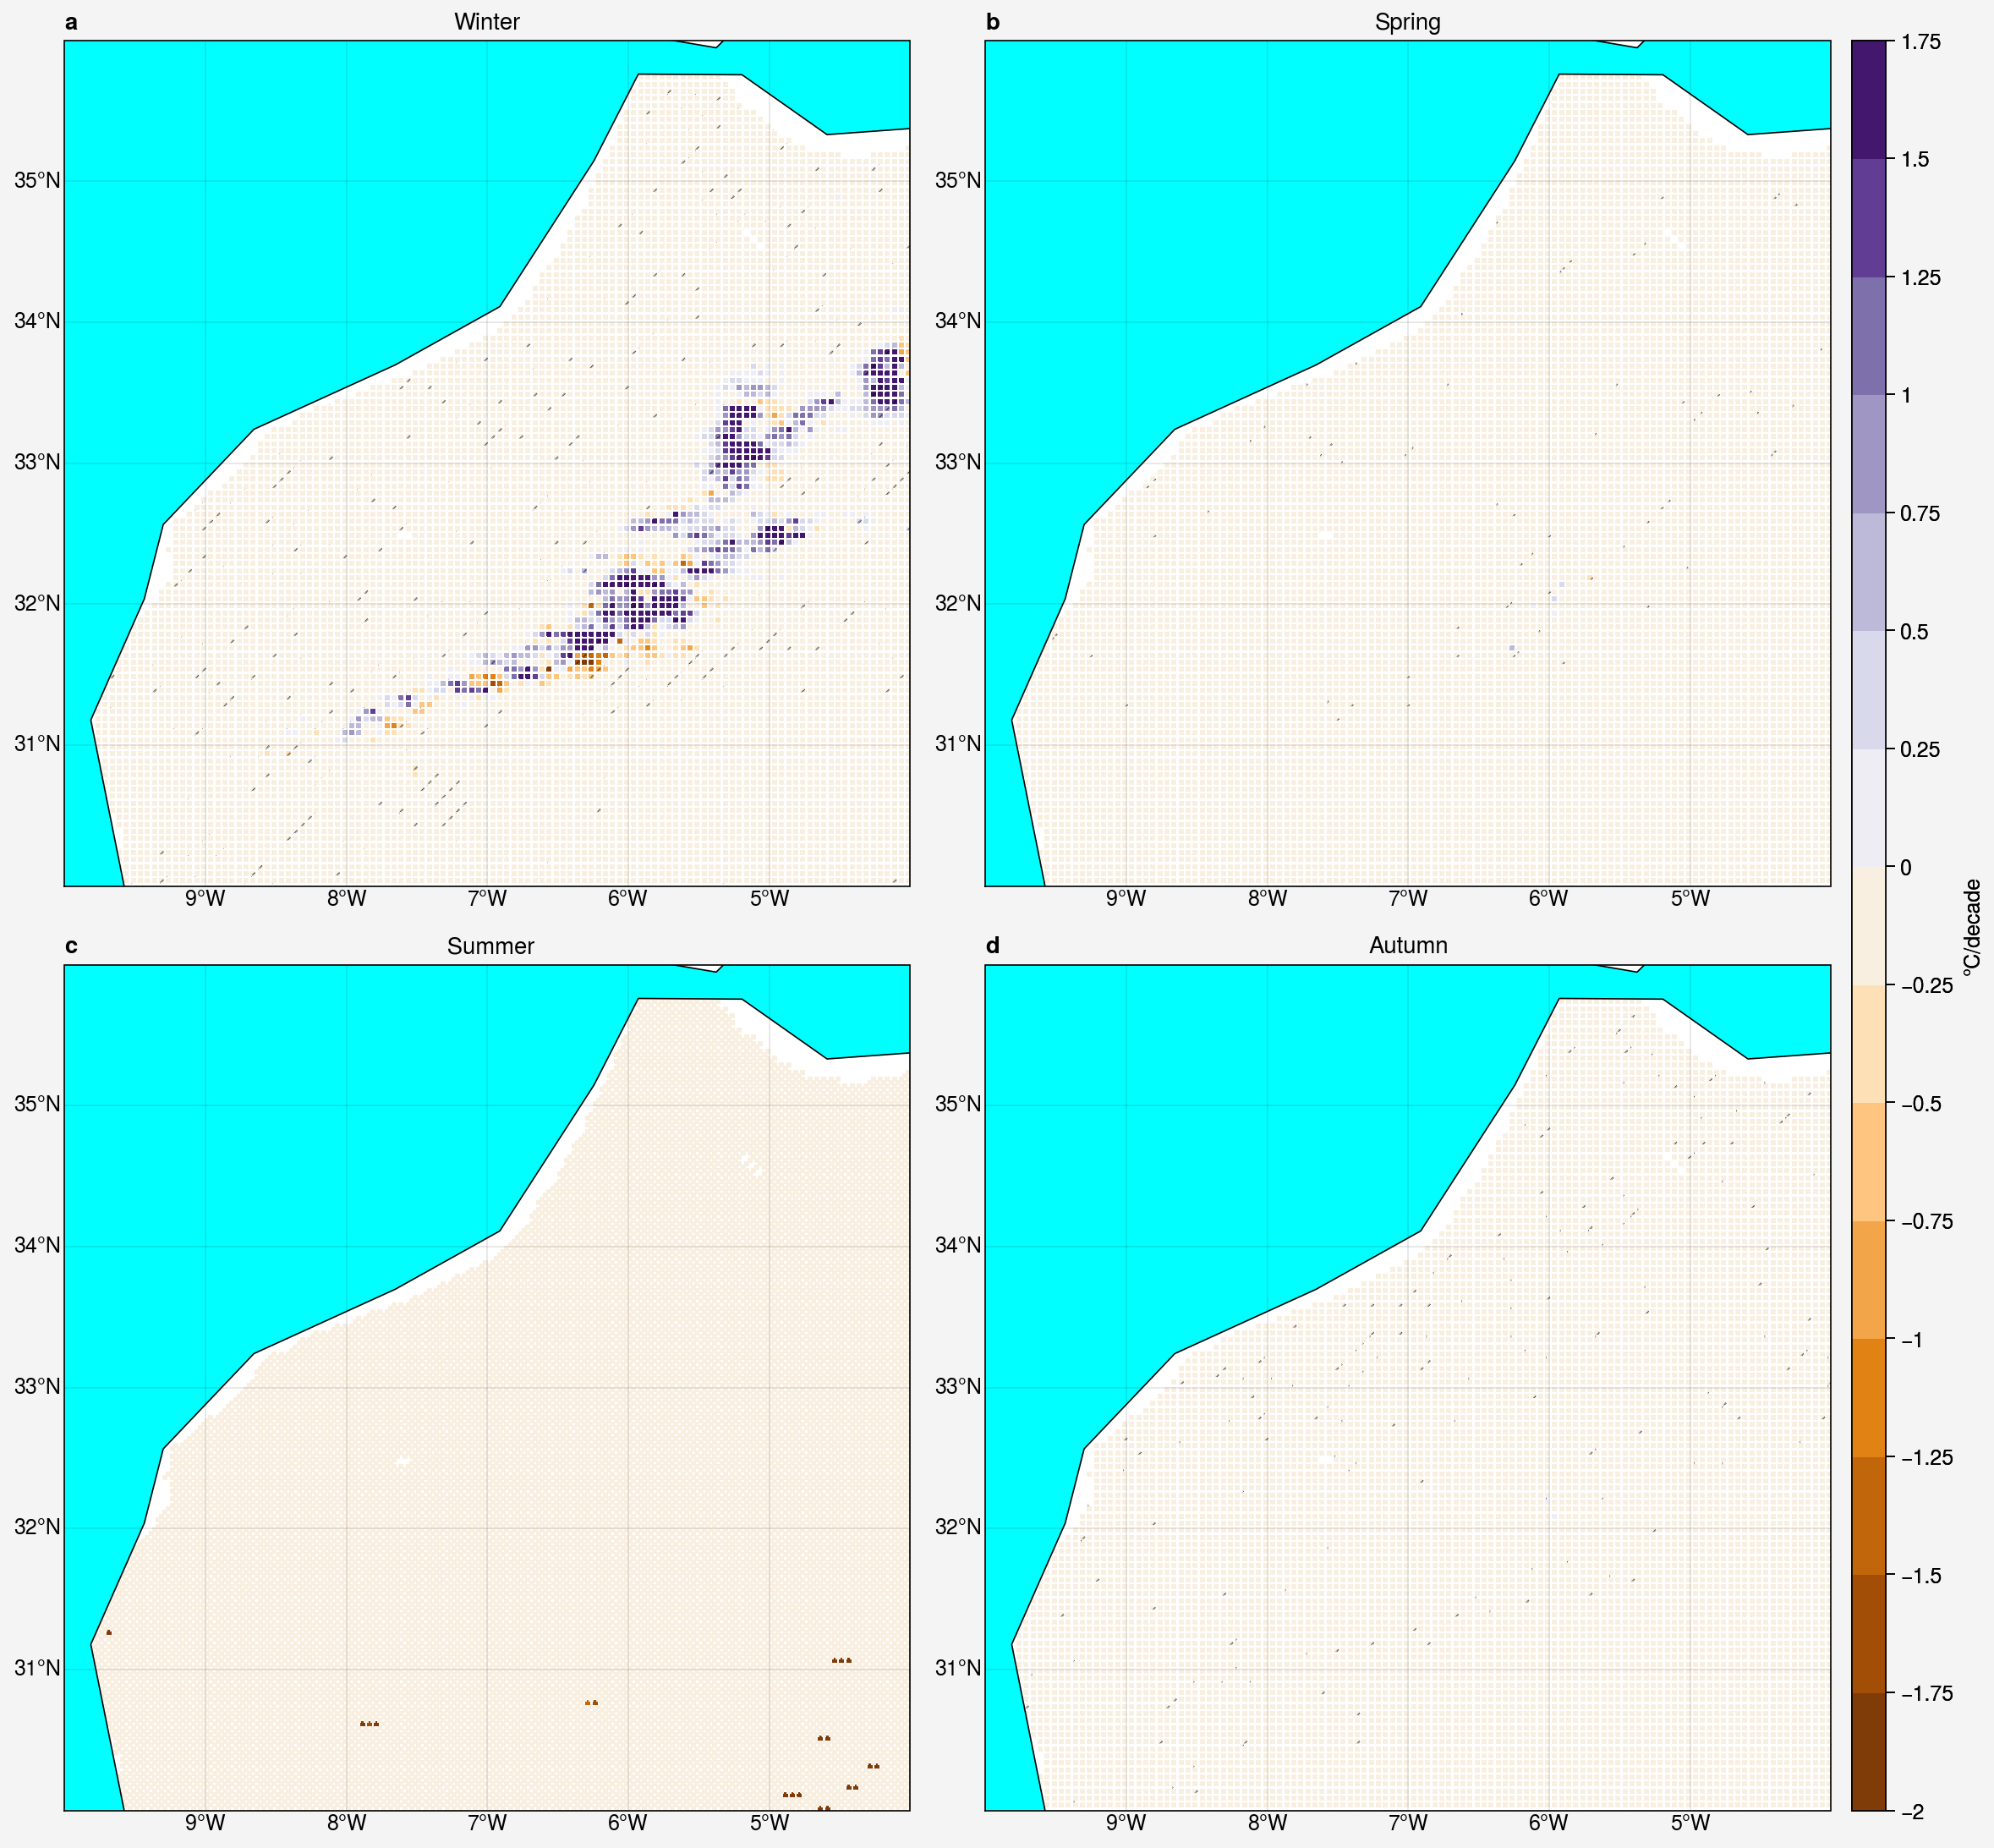

In [38]:
# Plote
# 1) # Masking significativity
signif=np.where(pvalue_scfv<0.05, True,False)

# Levels of scfv for the plot
levels=np.arange(-2,2,0.25)
factor=10 # degree per decade

title={1:"Winter",2:"Spring",3:" Summer",4:"Autumn"}
# Producing the map of the trends, excluding the borders of the domain.
f, axs = plot.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        aux.lon,aux.lat,
        slope_scfv[i,:,:]*factor,
        levels=levels,
        cmap='PuOr'  
    )
    ax.format(title=title[i+1])   # font.largesize=='20px'
    
    p = ax.contourf(
    aux.lon,aux.lat,
    signif[i,:,:],
    hatches=["", "//"], alpha=0
    )
    
f.colorbar(m, label= '°C/decade')

axs.format(
    labels=True,
    coast=True, ocean=True, oceancolor='cyan', landcolor='bisque',borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()

<h1 style="font-size:1.2rem; color:black;"> Computing trends with Hamed and Rao Modified MK Test: </h1> 

<h1 style="font-size:1.2rem; color:black;"> This modified MK test proposed by Hamed and Rao (1998) to address serial autocorrelation issues. They suggested a variance correction approach to improve trend analysis. User can consider first n significant lag by insert lag number in this function. By default, it considered all significant lags. </h1>

In [39]:
slope_scfv=np.full(seas_scfv.shape[1:4], np.nan)
pvalue_scfv=np.full(seas_scfv.shape[1:4], np.nan)  
for lon in range(seas_scfv.shape[3]):                        
    print(str(lon)+'/'+str(seas_scfv.shape[3]))
    for lat in range(seas_scfv.shape[2]):                  
        for seas in range(4):
            try:
                mk_scfv = mk.hamed_rao_modification_test(seas_scfv[1:,seas,lat,lon])
                slope_scfv[seas][lat][lon] = mk_scfv.slope
                pvalue_scfv[seas][lat][lon] = mk_scfv.p
            except:
                ZeroDivisionError

0/400
1/400


/home/hamid/anaconda3/envs/my_env/lib/python3.9/site-packages/pymannkendall/pymannkendall.py:60: RuntimeWarning: invalid value encountered in true_divide
  return acov[:nlags+1]/acov[0]


2/400
3/400
4/400
5/400
6/400
7/400
8/400
9/400
10/400
11/400
12/400
13/400
14/400
15/400
16/400
17/400
18/400
19/400


/home/hamid/anaconda3/envs/my_env/lib/python3.9/site-packages/pymannkendall/pymannkendall.py:99: RuntimeWarning: invalid value encountered in sqrt
  z = (s - 1)/np.sqrt(var_s)


20/400
21/400
22/400
23/400
24/400
25/400
26/400
27/400
28/400
29/400
30/400
31/400


/home/hamid/anaconda3/envs/my_env/lib/python3.9/site-packages/pymannkendall/pymannkendall.py:103: RuntimeWarning: invalid value encountered in sqrt
  z = (s + 1)/np.sqrt(var_s)


32/400
33/400
34/400
35/400
36/400
37/400
38/400
39/400
40/400
41/400
42/400
43/400
44/400
45/400
46/400
47/400
48/400
49/400
50/400
51/400
52/400
53/400
54/400
55/400
56/400
57/400
58/400
59/400
60/400
61/400
62/400
63/400
64/400
65/400
66/400
67/400
68/400
69/400
70/400
71/400
72/400
73/400
74/400
75/400
76/400
77/400
78/400
79/400
80/400
81/400
82/400
83/400
84/400
85/400
86/400
87/400
88/400
89/400
90/400
91/400
92/400
93/400
94/400
95/400
96/400
97/400
98/400
99/400
100/400
101/400
102/400
103/400
104/400
105/400
106/400
107/400
108/400
109/400
110/400
111/400
112/400
113/400
114/400
115/400
116/400
117/400
118/400
119/400
120/400
121/400
122/400
123/400
124/400
125/400
126/400
127/400
128/400
129/400
130/400
131/400
132/400
133/400
134/400
135/400
136/400
137/400
138/400
139/400
140/400
141/400
142/400
143/400
144/400
145/400
146/400
147/400
148/400
149/400
150/400
151/400
152/400
153/400
154/400
155/400
156/400
157/400
158/400
159/400
160/400
161/400
162/400
163/400
164/400
165/

In [40]:
print("=========================== slope_scfv ===============================")
print(slope_scfv)
print("=========================== pvalue_scfv ===============================")
print(pvalue_scfv)

=========================== slope_scfv ===============================
[[[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
=========================== pvalue_scfv ===============================
[[[       nan        nan        nan ...        nan       

i=0
ax=<_CartopyAxesSubplot:label='subplot_1'>
i=1
ax=<_CartopyAxesSubplot:label='subplot_2'>
i=2
ax=<_CartopyAxesSubplot:label='subplot_3'>
i=3
ax=<_CartopyAxesSubplot:label='subplot_4'>


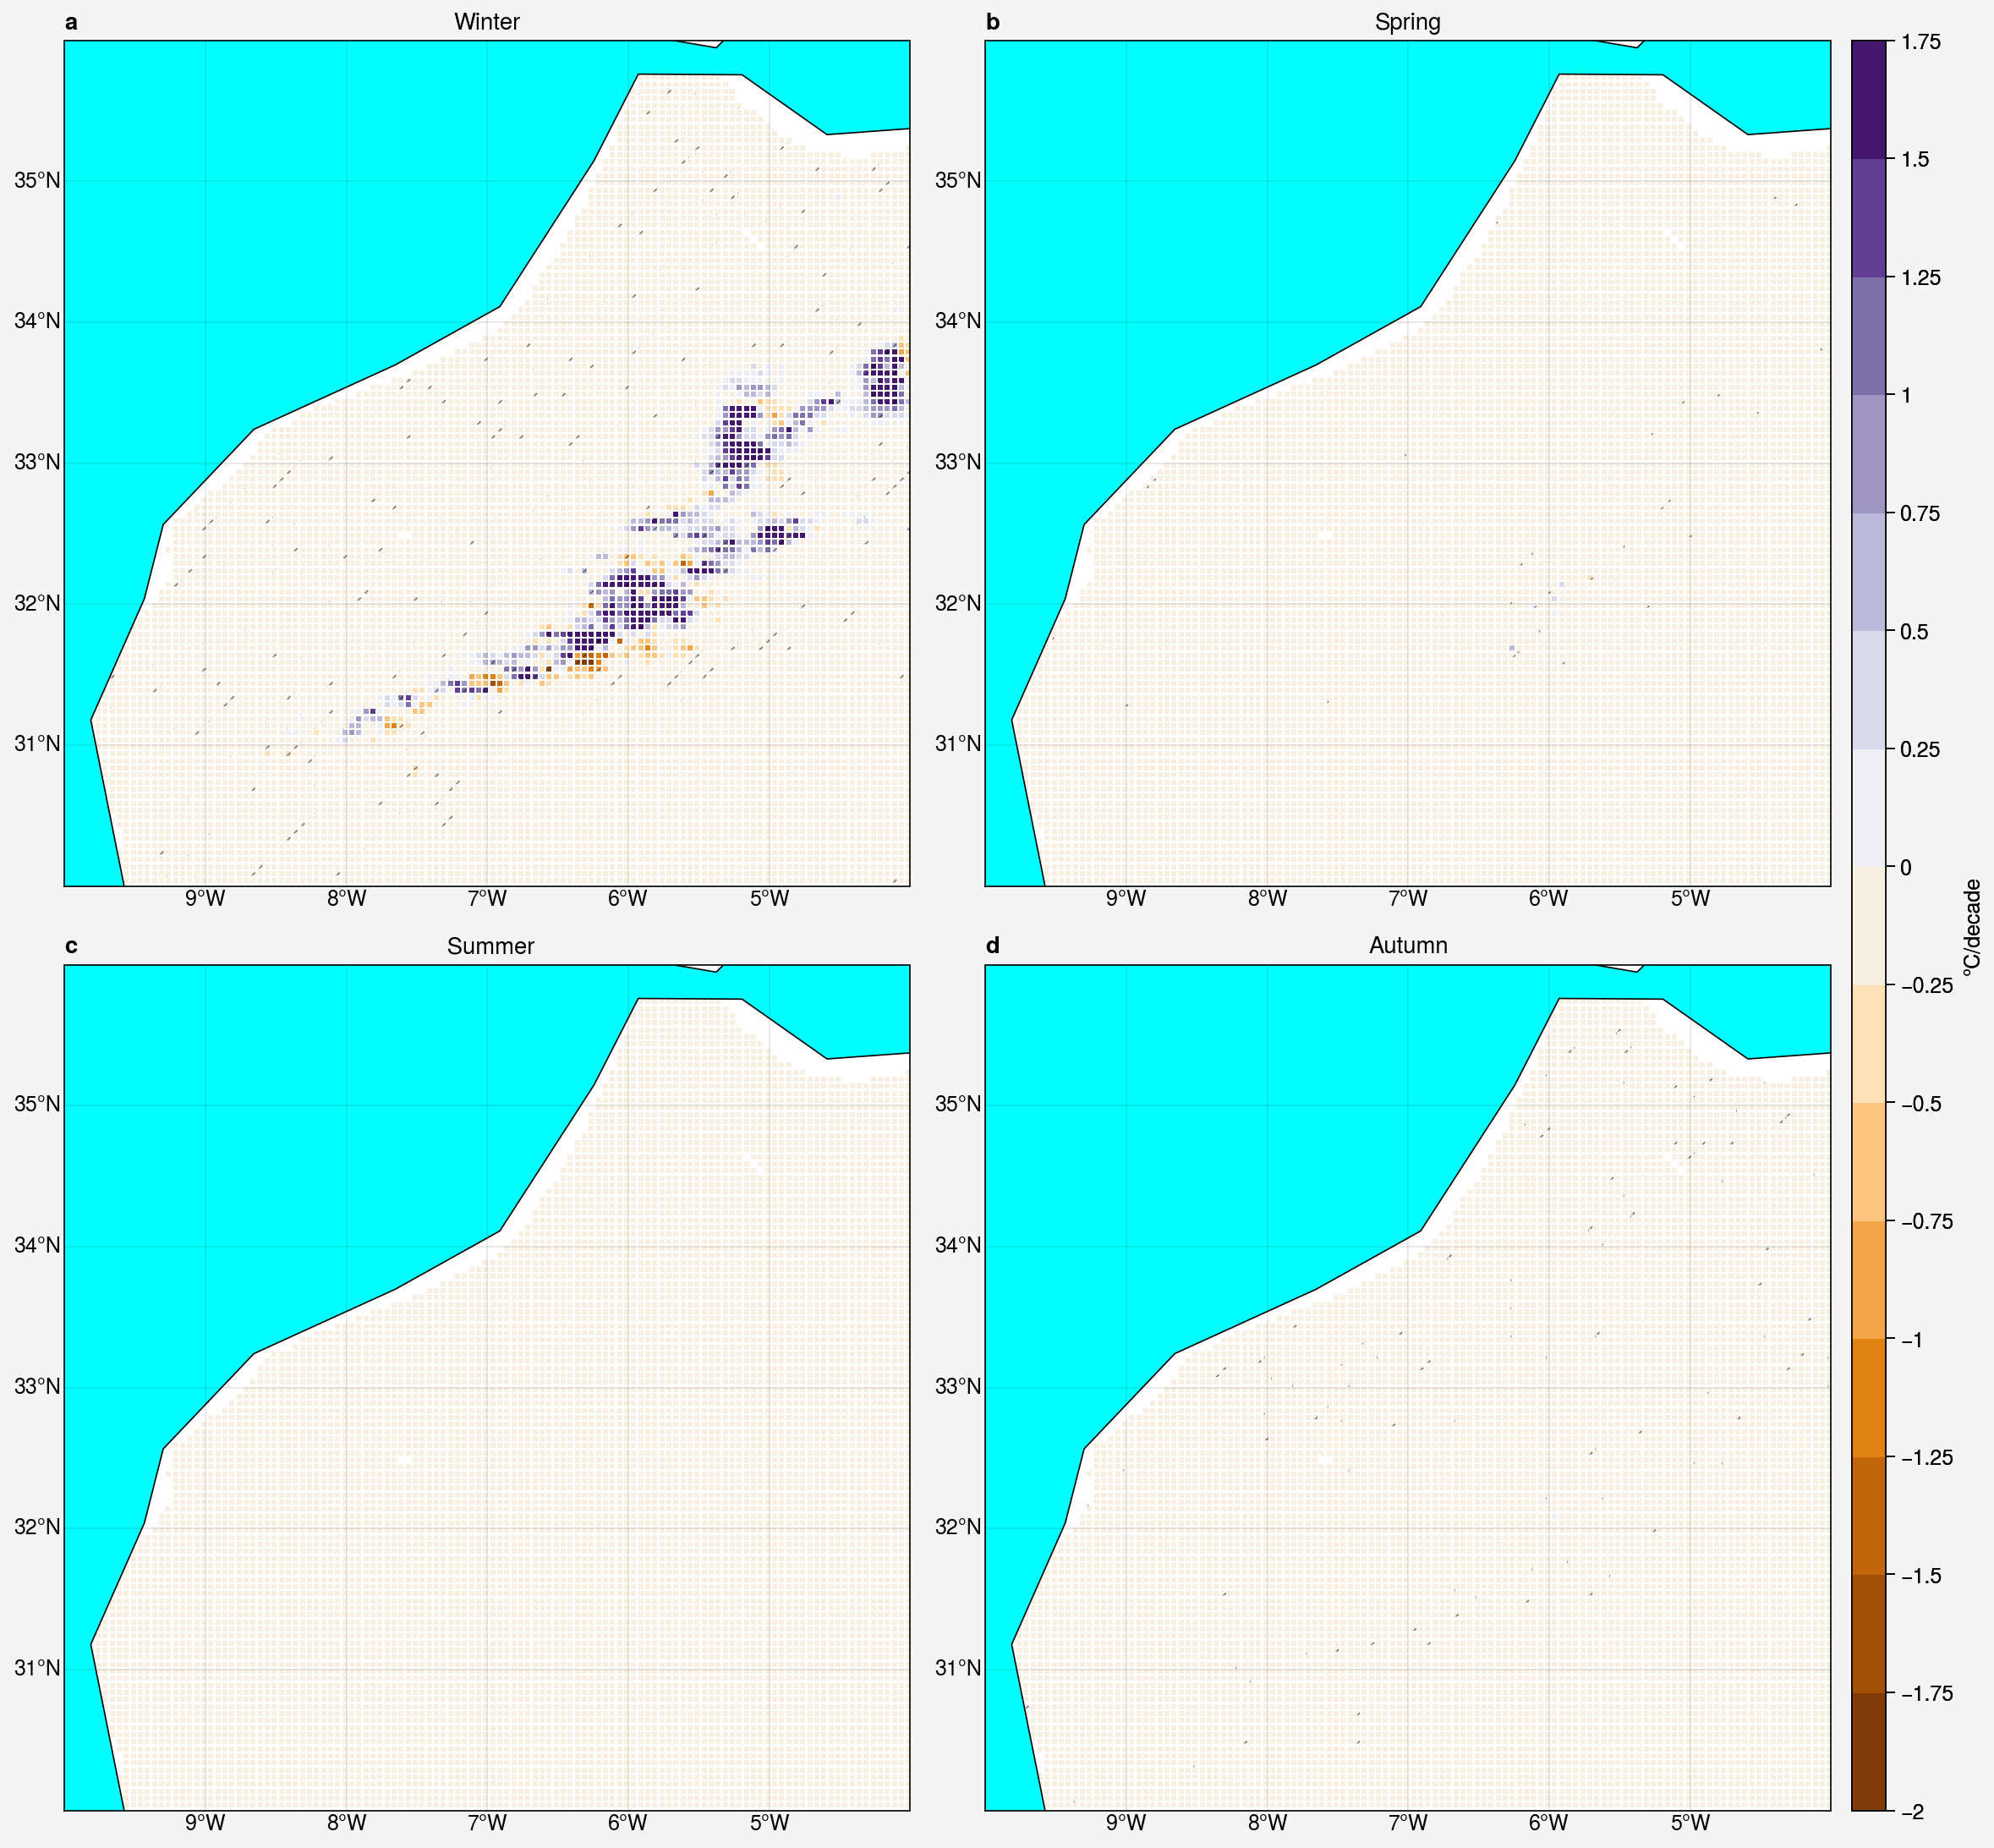

In [41]:
# Plote
# 1) # Masking significativity
signif=np.where(pvalue_scfv<0.05, True,False)

# Levels of scfv for the plot
levels=np.arange(-2,2,0.25)
factor=10 # degree per decade

title={1:"Winter",2:"Spring",3:" Summer",4:"Autumn"}
# Producing the map of the trends, excluding the borders of the domain.
f, axs = plot.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        aux.lon,aux.lat,
        slope_scfv[i,:,:]*factor,
        levels=levels,
        cmap='PuOr'  
    )
    ax.format(title=title[i+1])   # font.largesize=='20px'
    
    p = ax.contourf(
    aux.lon,aux.lat,
    signif[i,:,:],
    hatches=["", "//"], alpha=0
    )
    
f.colorbar(m, label= '°C/decade')

axs.format(
    labels=True,
    coast=True, ocean=True, oceancolor='cyan', landcolor='bisque',borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()

<h1 style="font-size:1.2rem; color:black;"> Computing trends with Yue and Wang Modified MK Test: </h1>

<h1 style="font-size:1.2rem; color:black;"> This is also a variance correction method for considered serial autocorrelation proposed by Yue, S., & Wang, C. Y. (2004). User can also set their desired significant n lags for the calculation. </h1>

In [42]:
slope_scfv=np.full(seas_scfv.shape[1:4], np.nan)
pvalue_scfv=np.full(seas_scfv.shape[1:4], np.nan)  
for lon in range(seas_scfv.shape[3]):                        
    print(str(lon)+'/'+str(seas_scfv.shape[3]))
    for lat in range(seas_scfv.shape[2]):                  
        for seas in range(4):
            try:
                mk_scfv = mk.yue_wang_modification_test(seas_scfv[1:,seas,lat,lon])
                slope_scfv[seas][lat][lon] = mk_scfv.slope
                pvalue_scfv[seas][lat][lon] = mk_scfv.p
            except:
                ZeroDivisionError

0/400
1/400


/home/hamid/anaconda3/envs/my_env/lib/python3.9/site-packages/pymannkendall/pymannkendall.py:60: RuntimeWarning: invalid value encountered in true_divide
  return acov[:nlags+1]/acov[0]


2/400
3/400
4/400
5/400
6/400
7/400
8/400
9/400
10/400
11/400
12/400
13/400
14/400
15/400
16/400
17/400
18/400
19/400
20/400
21/400
22/400
23/400
24/400
25/400
26/400
27/400
28/400
29/400
30/400
31/400
32/400
33/400
34/400
35/400
36/400
37/400
38/400
39/400
40/400
41/400
42/400
43/400
44/400
45/400
46/400
47/400
48/400
49/400
50/400
51/400
52/400
53/400
54/400
55/400
56/400
57/400
58/400
59/400
60/400
61/400
62/400
63/400
64/400
65/400
66/400
67/400
68/400
69/400
70/400
71/400
72/400
73/400
74/400
75/400
76/400
77/400
78/400
79/400
80/400
81/400
82/400
83/400
84/400
85/400
86/400
87/400
88/400
89/400
90/400
91/400
92/400
93/400
94/400
95/400
96/400
97/400
98/400
99/400
100/400
101/400
102/400
103/400
104/400
105/400
106/400
107/400
108/400
109/400
110/400
111/400
112/400
113/400
114/400
115/400
116/400
117/400
118/400
119/400
120/400
121/400
122/400
123/400
124/400
125/400
126/400
127/400
128/400
129/400
130/400
131/400
132/400
133/400
134/400
135/400
136/400
137/400
138/400
139/400
14

In [43]:
print("=========================== slope_scfv ===============================")
print(slope_scfv)
print("=========================== pvalue_scfv ===============================")
print(pvalue_scfv)

=========================== slope_scfv ===============================
[[[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[ 0. nan  0. ... nan  0. nan]
  [nan  0. nan ...  0. nan  0.]
  [ 0. nan  0. ... nan  0. nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
=========================== pvalue_scfv ===============================
[[[       nan        nan        nan ...        nan       

i=0
ax=<_CartopyAxesSubplot:label='subplot_1'>
i=1
ax=<_CartopyAxesSubplot:label='subplot_2'>
i=2
ax=<_CartopyAxesSubplot:label='subplot_3'>
i=3
ax=<_CartopyAxesSubplot:label='subplot_4'>


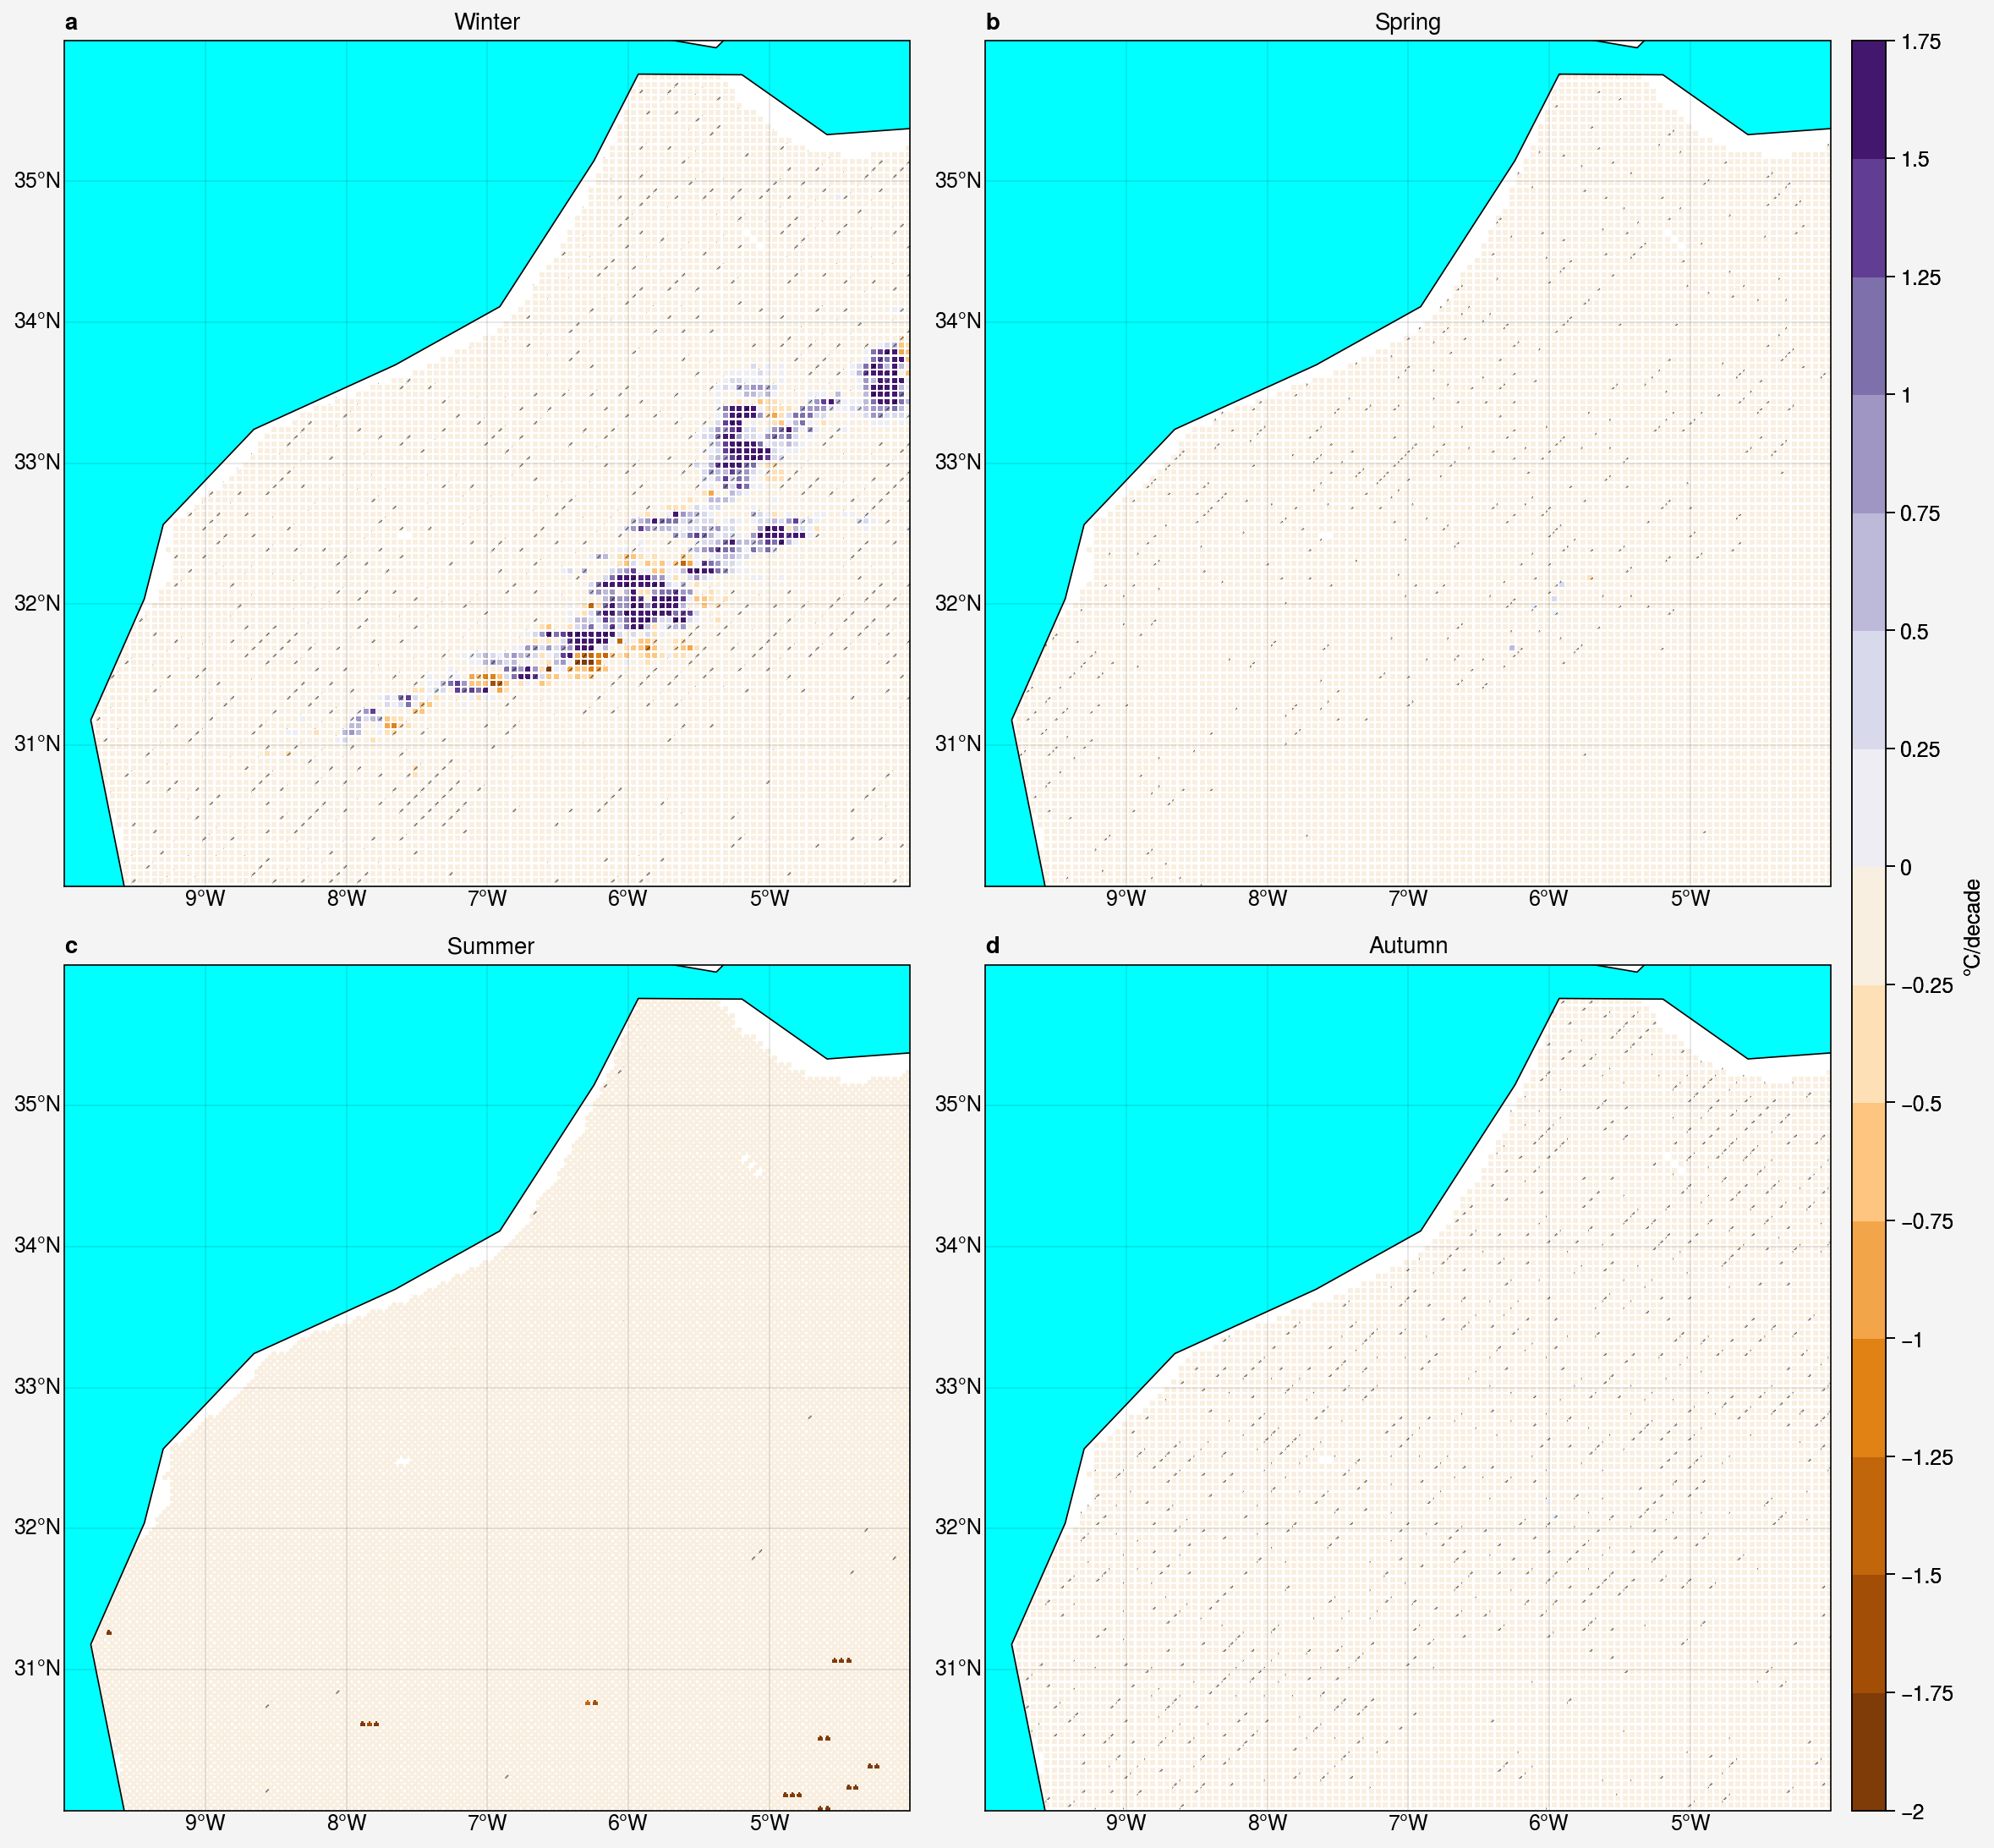

In [44]:
# Plote
# 1) # Masking significativity
signif=np.where(pvalue_scfv<0.05, True,False)

# Levels of scfv for the plot
levels=np.arange(-2,2,0.25)
factor=10 # degree per decade

title={1:"Winter",2:"Spring",3:" Summer",4:"Autumn"}
# Producing the map of the trends, excluding the borders of the domain.
f, axs = plot.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        aux.lon,aux.lat,
        slope_scfv[i,:,:]*factor,
        levels=levels,
        cmap='PuOr'  
    )
    ax.format(title=title[i+1])   # font.largesize=='20px'
    
    p = ax.contourf(
    aux.lon,aux.lat,
    signif[i,:,:],
    hatches=["", "//"], alpha=0
    )
    
f.colorbar(m, label= '°C/decade')

axs.format(
    labels=True,
    coast=True, ocean=True, oceancolor='cyan', landcolor='bisque',borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()

<h1 style="font-size:1.2rem; color:black;"> Computing trends with Modified MK test using Pre-Whitening method  </h1>

<h1 style="font-size:1rem; color:black;"> This test suggested by Yue and Wang (2002) to using Pre-Whitening the time series before the application of trend test. </h1>

slope_scfv=np.full(seas_scfv.shape[1:4], np.nan)
pvalue_scfv=np.full(seas_scfv.shape[1:4], np.nan)  
for lon in range(seas_scfv.shape[3]):                        
    print(str(lon)+'/'+str(seas_scfv.shape[3]))
    for lat in range(seas_scfv.shape[2]):                  
        for seas in range(4):
            try:
                mk_scfv = mk.pre_whitening_modification_test(seas_scfv[1:,seas,lat,lon])
                slope_scfv[seas][lat][lon] = mk_scfv.slope
                pvalue_scfv[seas][lat][lon] = mk_scfv.p
            except:
                ZeroDivisionError

In [46]:
print("=========================== slope_scfv ===============================")
print(slope_scfv)
print("=========================== pvalue_scfv ===============================")
print(pvalue_scfv)

=========================== slope_scfv ===============================
[[[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
=========================== pvalue_scfv ===============================
[[[       nan        nan        nan ...        nan       

i=0
ax=<_CartopyAxesSubplot:label='subplot_1'>
i=1
ax=<_CartopyAxesSubplot:label='subplot_2'>
i=2
ax=<_CartopyAxesSubplot:label='subplot_3'>
i=3
ax=<_CartopyAxesSubplot:label='subplot_4'>


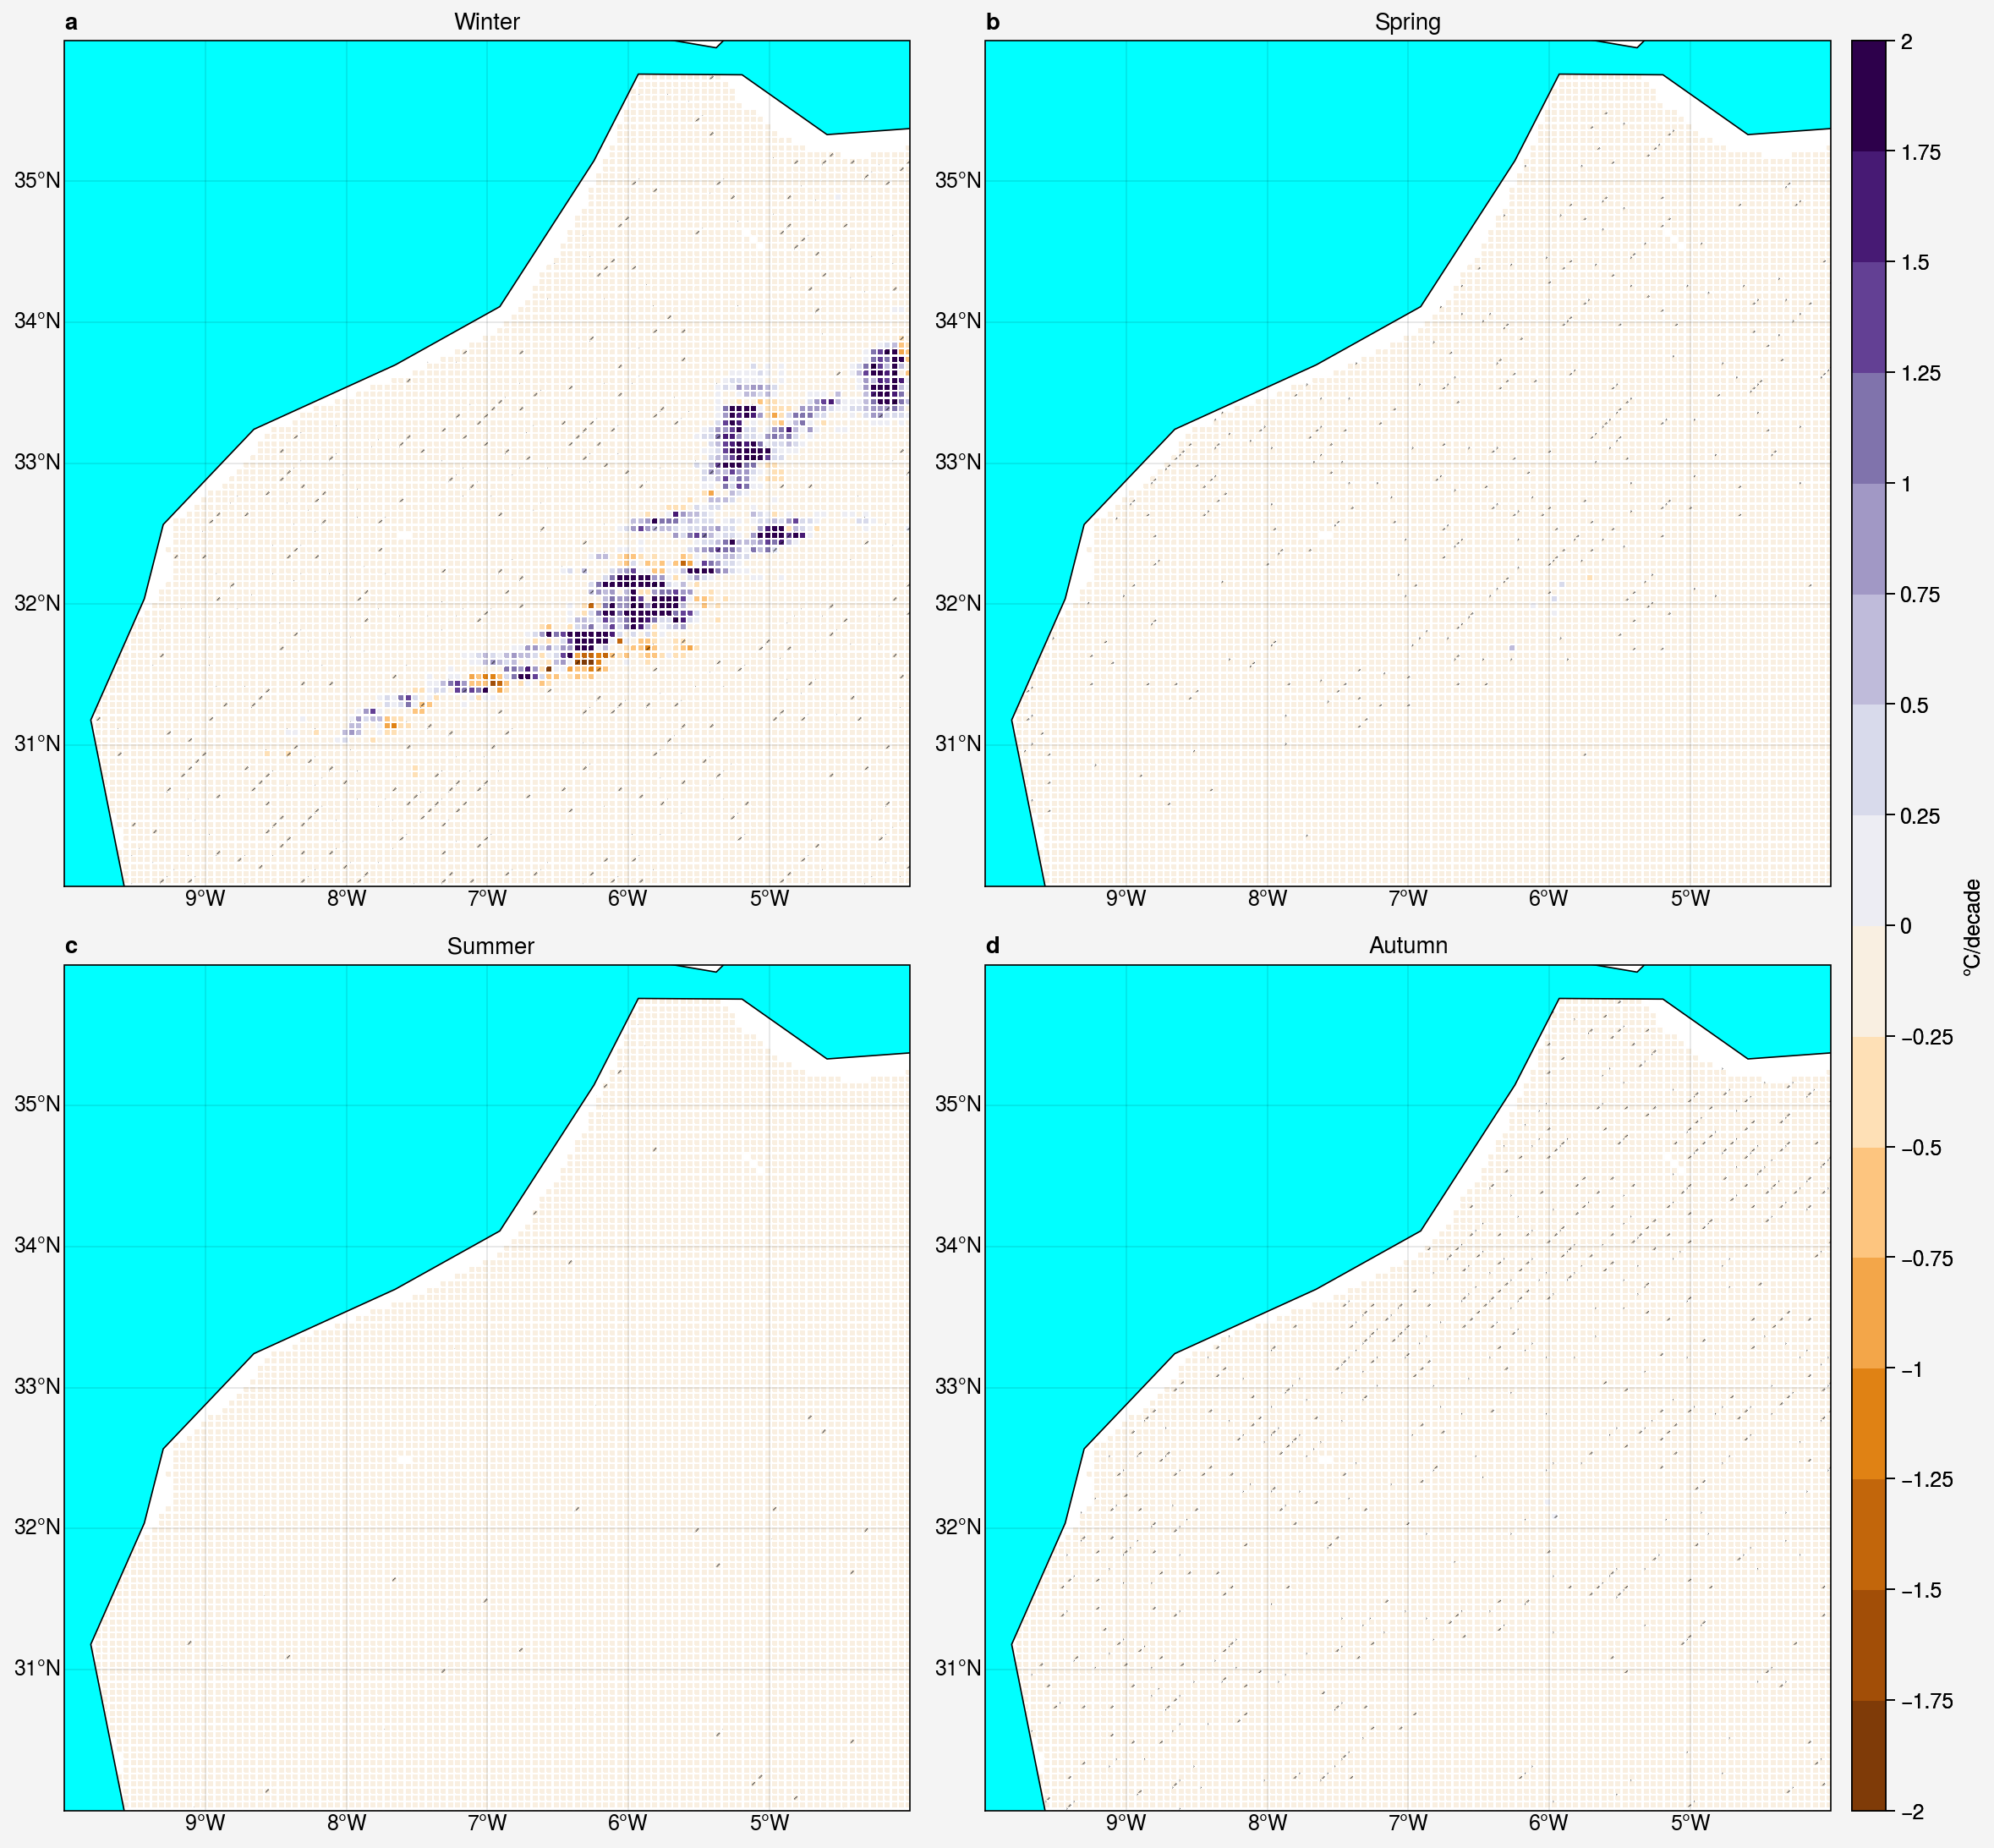

In [48]:
# Plote
# 1) # Masking significativity
signif=np.where(pvalue_scfv<0.05, True,False)

# Levels of scfv for the plot
levels=np.arange(-2,2.25,0.25)
factor=10 # degree per decade

title={1:"Winter",2:"Spring",3:" Summer",4:"Autumn"}
# Producing the map of the trends, excluding the borders of the domain.
f, axs = plot.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        aux.lon,aux.lat,
        slope_scfv[i,:,:]*factor,
        levels=levels,
        cmap='PuOr'  
    )
    ax.format(title=title[i+1])   # font.largesize=='20px'
    
    p = ax.contourf(
    aux.lon,aux.lat,
    signif[i,:,:],
    hatches=["", "//"], alpha=0
    )
    
f.colorbar(m, label= '°C/decade')

axs.format(
    labels=True,
    coast=True, ocean=True, oceancolor='cyan', landcolor='bisque',borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()

<h1 style="font-size:1.2rem; color:black;"> Computing trends with seasonal_test: </h1>

<h1 style="font-size:1rem; color:black;"> For seasonal time series data, Hirsch, R.M., Slack, J.R. and Smith, R.A. (1982) proposed this test to calculate the seasonal trend. </h1>

In [57]:
slope_scfv=np.full(seas_scfv.shape[1:4], np.nan)
pvalue_scfv=np.full(seas_scfv.shape[1:4], np.nan)  
for lon in range(seas_scfv.shape[3]):                        
    print(str(lon)+'/'+str(seas_scfv.shape[3]))
    for lat in range(seas_scfv.shape[2]):                  
        for seas in range(4):
            try:
                mk_scfv = mk.regional_test(seas_scfv[1:,seas,lat,lon])
                slope_scfv[seas][lat][lon] = mk_scfv.slope
                pvalue_scfv[seas][lat][lon] = mk_scfv.p
            except:
                ZeroDivisionError

0/400
1/400
2/400
3/400
4/400
5/400
6/400
7/400
8/400
9/400
10/400
11/400
12/400
13/400
14/400
15/400
16/400
17/400
18/400
19/400
20/400
21/400
22/400
23/400
24/400
25/400
26/400
27/400
28/400
29/400
30/400
31/400
32/400
33/400
34/400
35/400
36/400
37/400
38/400
39/400
40/400
41/400
42/400
43/400
44/400
45/400
46/400
47/400
48/400
49/400
50/400
51/400
52/400
53/400
54/400
55/400
56/400
57/400
58/400
59/400
60/400
61/400
62/400
63/400
64/400
65/400
66/400
67/400
68/400
69/400
70/400
71/400
72/400
73/400
74/400
75/400
76/400
77/400
78/400
79/400
80/400
81/400
82/400
83/400
84/400
85/400
86/400
87/400
88/400
89/400
90/400
91/400
92/400
93/400
94/400
95/400
96/400
97/400
98/400
99/400
100/400
101/400
102/400
103/400
104/400
105/400
106/400
107/400
108/400
109/400
110/400
111/400
112/400
113/400
114/400
115/400
116/400
117/400
118/400
119/400
120/400
121/400
122/400
123/400
124/400
125/400
126/400
127/400
128/400
129/400
130/400
131/400
132/400
133/400
134/400
135/400
136/400
137/400
138/40

In [59]:
print("=========================== slope_scfv ===============================")
print(slope_scfv)
print("=========================== pvalue_scfv ===============================")
print(pvalue_scfv)

=========================== slope_scfv ===============================
[[[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[ 0. nan  0. ... nan  0. nan]
  [nan  0. nan ...  0. nan  0.]
  [ 0. nan  0. ... nan  0. nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
=========================== pvalue_scfv ===============================
[[[       nan        nan        nan ...        nan       

i=0
ax=<_CartopyAxesSubplot:label='subplot_1'>
i=1
ax=<_CartopyAxesSubplot:label='subplot_2'>
i=2
ax=<_CartopyAxesSubplot:label='subplot_3'>
i=3
ax=<_CartopyAxesSubplot:label='subplot_4'>


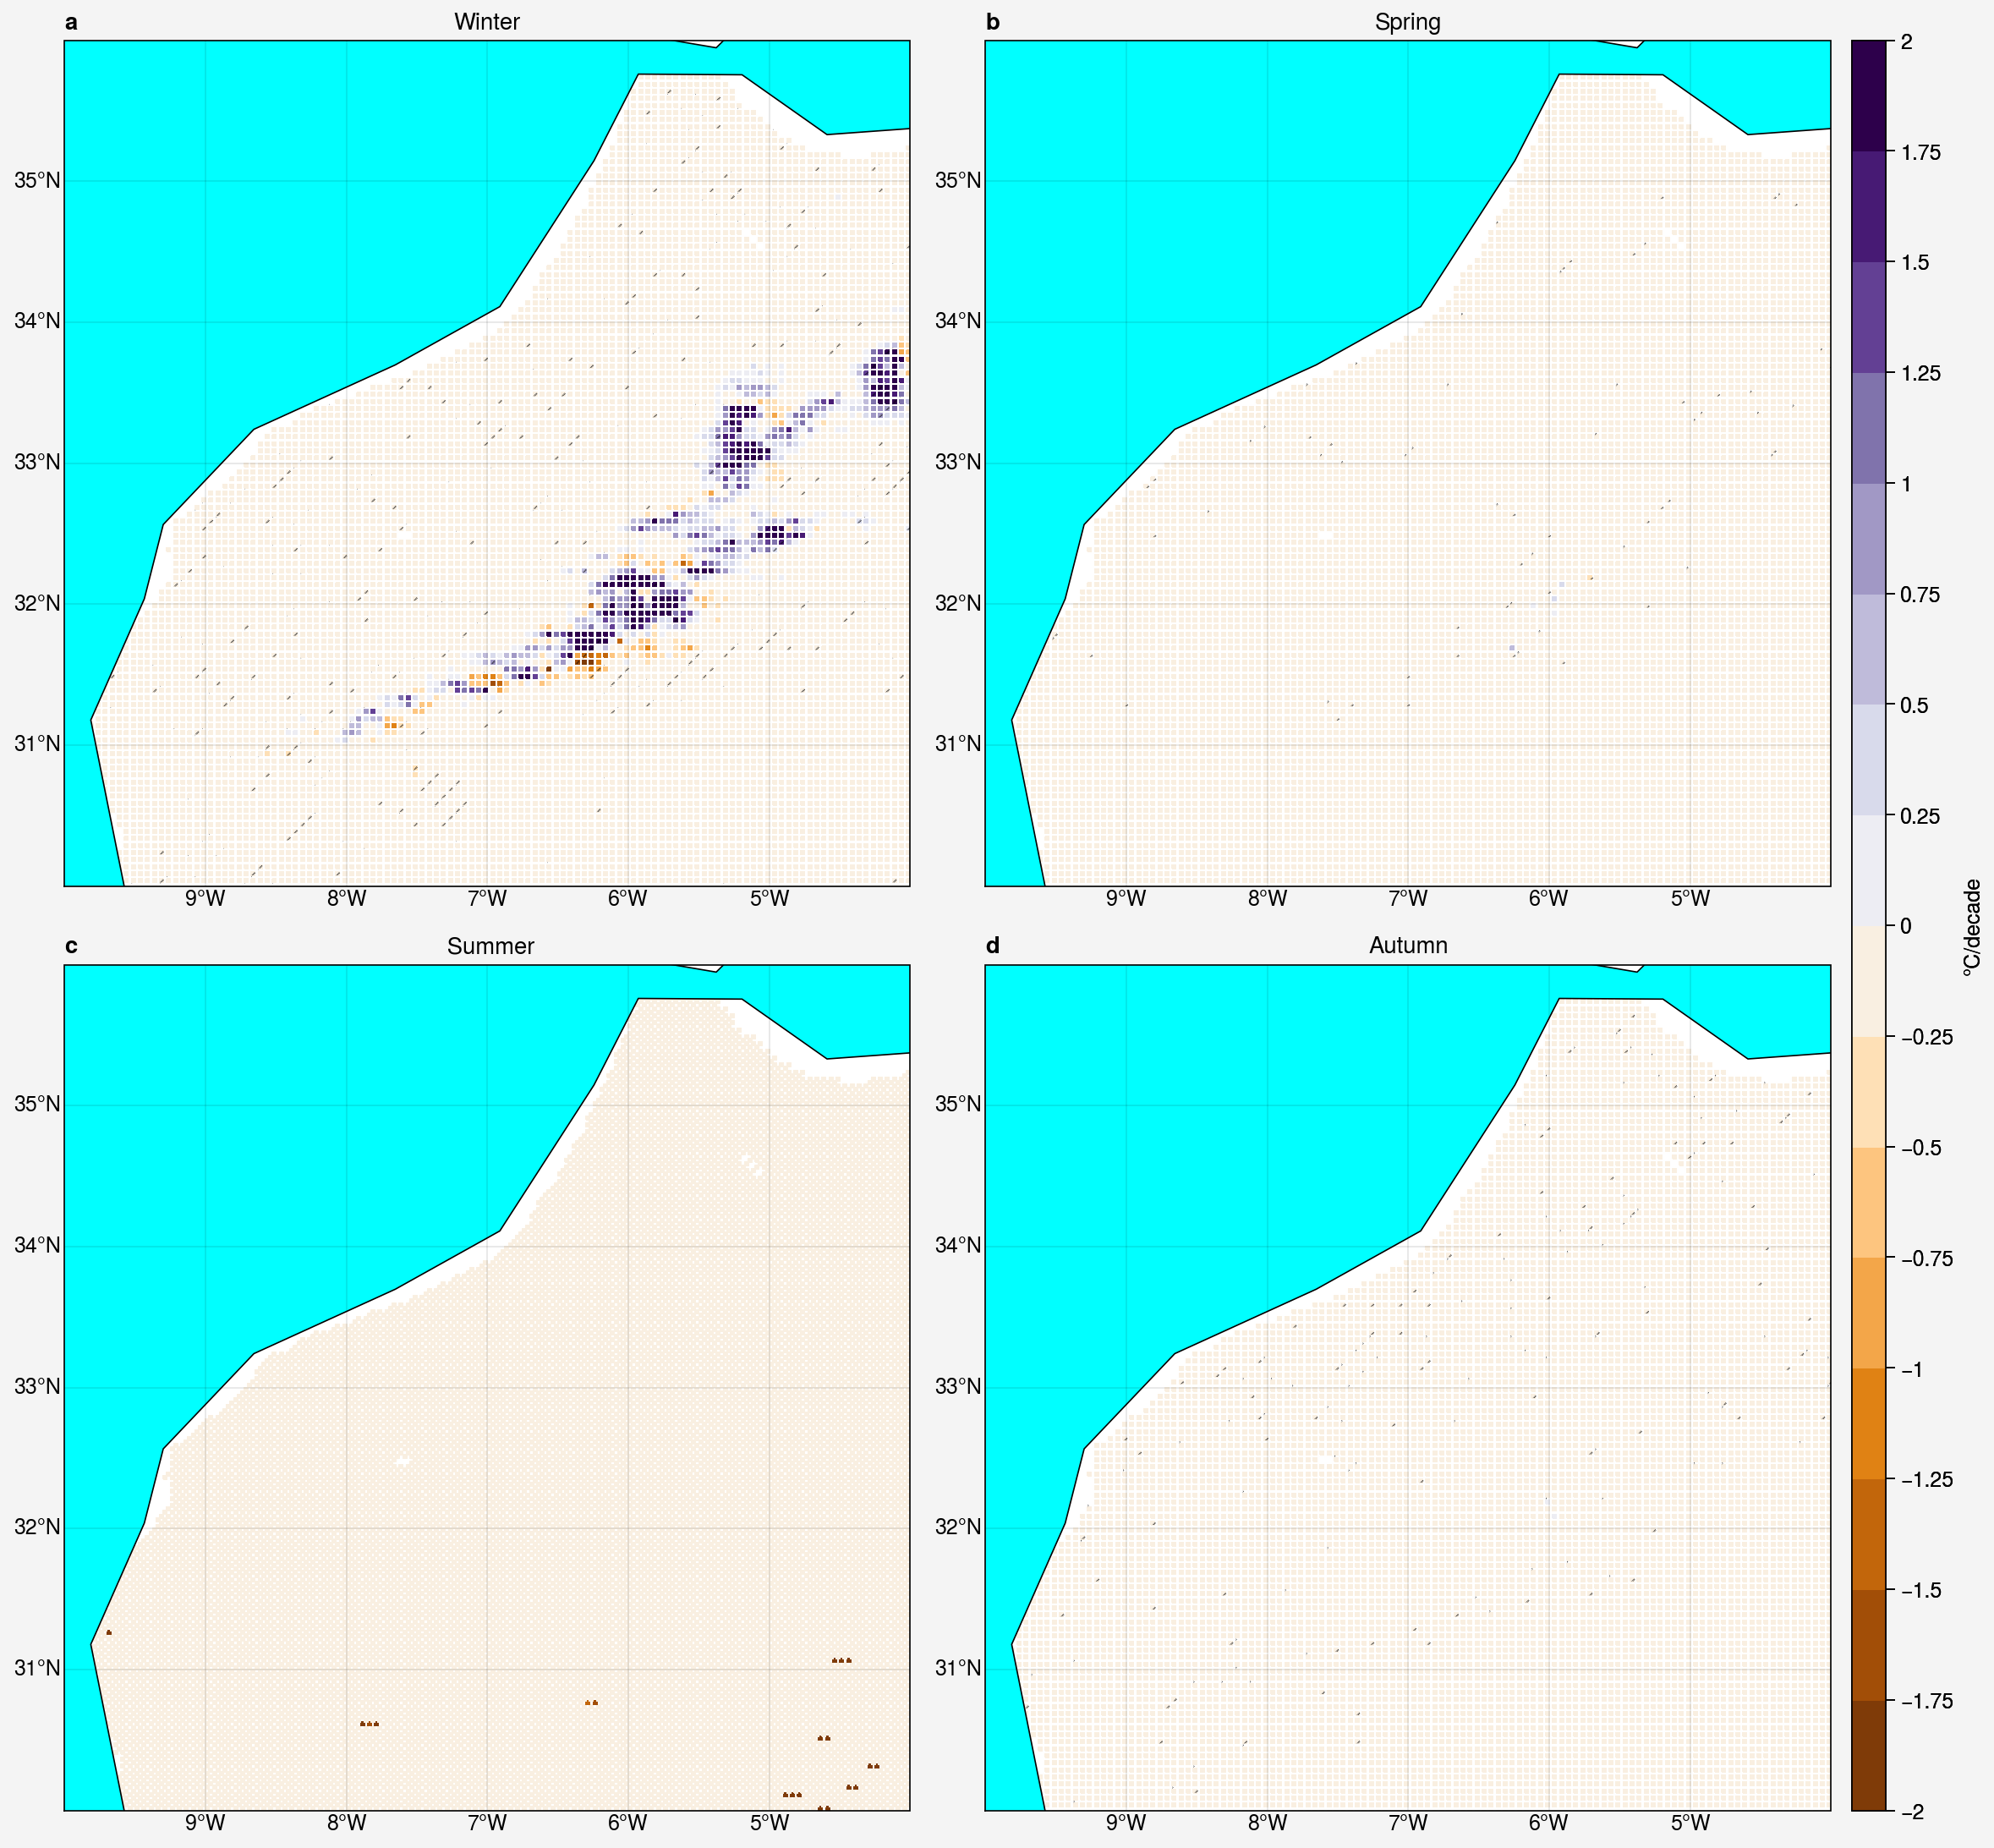

In [60]:
# Plote
# 1) # Masking significativity
signif=np.where(pvalue_scfv<0.05, True,False)

# Levels of scfv for the plot
levels=np.arange(-2,2.25,0.25)
factor=10 # degree per decade

title={1:"Winter",2:"Spring",3:" Summer",4:"Autumn"}
# Producing the map of the trends, excluding the borders of the domain.
f, axs = plot.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        aux.lon,aux.lat,
        slope_scfv[i,:,:]*factor,
        levels=levels,
        cmap='PuOr'  
    )
    ax.format(title=title[i+1])   # font.largesize=='20px'
    
    p = ax.contourf(
    aux.lon,aux.lat,
    signif[i,:,:],
    hatches=["", "//"], alpha=0
    )
    
f.colorbar(m, label= '°C/decade')

axs.format(
    labels=True,
    coast=True, ocean=True, oceancolor='cyan', landcolor='bisque',borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()

## =================================================================

## 6. Monthly trends over the period 1982-2018 with Mannkendall test

<h1 style="font-size:1.2rem; color:black;"> Monthly trends Original Mann-Kendall test: </h1>  

In [50]:
aux = scfv_atlas_filtred
mon_scfv=np.empty(shape=(time_period,12,aux.shape[1],aux.shape[2]), dtype=float)
print(mon_scfv.shape)

(37, 12, 320, 400)


In [51]:
aux

<xarray.DataArray 'scfv' (time: 13093, lat: 320, lon: 400)>
dask.array<where, shape=(13093, 320, 400), dtype=float32, chunksize=(1, 320, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -9.975 -9.975 -9.925 ... -0.075 -0.02501 -0.025
  * lat      (lat) float64 28.02 28.02 28.07 28.08 ... 35.92 35.92 35.97 35.97
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2018-12-30
Attributes:
    standard_name:        snow_area_fraction_viewable_from_above
    long_name:            Snow Cover Fraction Viewable
    units:                percent
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    ancillary_variables:  scfv_unc

In [52]:
print(aux.where(aux['time.month'] == 1).groupby('time.year').mean(dim='time'))

<xarray.DataArray 'scfv' (year: 37, lat: 320, lon: 400)>
dask.array<stack, shape=(37, 320, 400), dtype=float32, chunksize=(1, 320, 400), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -9.975 -9.975 -9.925 ... -0.075 -0.02501 -0.025
  * lat      (lat) float64 28.02 28.02 28.07 28.08 ... 35.92 35.92 35.97 35.97
  * year     (year) int64 1982 1983 1984 1985 1986 ... 2014 2015 2016 2017 2018


In [53]:
for m in range(1,13):
    mon_scfv [:,m-1,:,:] = aux.where(aux['time.month'] == m).groupby('time.year').mean(dim='time')
    print("done for the "+str(m)+"th month")

done for the 1th month
done for the 2th month
done for the 3th month
done for the 4th month
done for the 5th month
done for the 6th month
done for the 7th month
done for the 8th month
done for the 9th month
done for the 10th month
done for the 11th month
done for the 12th month


In [54]:
mon_scfv

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan,  0., nan, ...,  0., nan,  0.],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan,  0., nan, ...,  0., nan,  0.],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan,  0., nan, ...,  0., nan,  0.],
         [nan, nan

In [63]:
# Computing trends    
slope_scfv=np.full(mon_scfv.shape[1:4], np.nan)
pvalue_scfv=np.full(mon_scfv.shape[1:4], np.nan)  
for lon in range(mon_scfv.shape[3]):                        
    print(str(lon)+'/'+str(mon_scfv.shape[3]))
    for lat in range(mon_scfv.shape[2]):
        for mon in range(12): 
            try:
                mk_scfv = mk.original_test(mon_scfv[1:,mon,lat,lon])
                slope_scfv[mon][lat][lon] = mk_scfv.slope
                pvalue_scfv[mon][lat][lon] = mk_scfv.p
            except:
                ZeroDivisionError

0/400
1/400
2/400
3/400
4/400
5/400
6/400
7/400
8/400
9/400
10/400
11/400
12/400
13/400
14/400
15/400
16/400
17/400
18/400
19/400
20/400
21/400
22/400
23/400
24/400
25/400
26/400
27/400
28/400
29/400
30/400
31/400
32/400
33/400
34/400
35/400
36/400
37/400
38/400
39/400
40/400
41/400
42/400
43/400
44/400
45/400
46/400
47/400
48/400
49/400
50/400
51/400
52/400
53/400
54/400
55/400
56/400
57/400
58/400
59/400
60/400
61/400
62/400
63/400
64/400
65/400
66/400
67/400
68/400
69/400
70/400
71/400
72/400
73/400
74/400
75/400
76/400
77/400
78/400
79/400
80/400
81/400
82/400
83/400
84/400
85/400
86/400
87/400
88/400
89/400
90/400
91/400
92/400
93/400
94/400
95/400
96/400
97/400
98/400
99/400
100/400
101/400
102/400
103/400
104/400
105/400
106/400
107/400
108/400
109/400
110/400
111/400
112/400
113/400
114/400
115/400
116/400
117/400
118/400
119/400
120/400
121/400
122/400
123/400
124/400
125/400
126/400
127/400
128/400
129/400
130/400
131/400
132/400
133/400
134/400
135/400
136/400
137/400
138/40

In [61]:
print("=========================== slope_scfv ===============================")
print(slope_scfv)
print("=========================== pvalue_scfv ===============================")
print(pvalue_scfv)

=========================== slope_scfv ===============================
[[[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[ 0. nan  0. ... nan  0. nan]
  [nan  0. nan ...  0. nan  0.]
  [ 0. nan  0. ... nan  0. nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ... nan nan nan]
  [nan  0. nan ...  0. nan  0.]
  [nan nan nan ... nan nan nan]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
=========================== pvalue_scfv ===============================
[[[       nan        nan        nan ...        nan       

i=0
ax=<_CartopyAxesSubplot:label='subplot_1'>
i=1
ax=<_CartopyAxesSubplot:label='subplot_2'>
i=2
ax=<_CartopyAxesSubplot:label='subplot_3'>
i=3
ax=<_CartopyAxesSubplot:label='subplot_4'>
i=4
ax=<_CartopyAxesSubplot:label='subplot_5'>


IndexError: index 4 is out of bounds for axis 0 with size 4

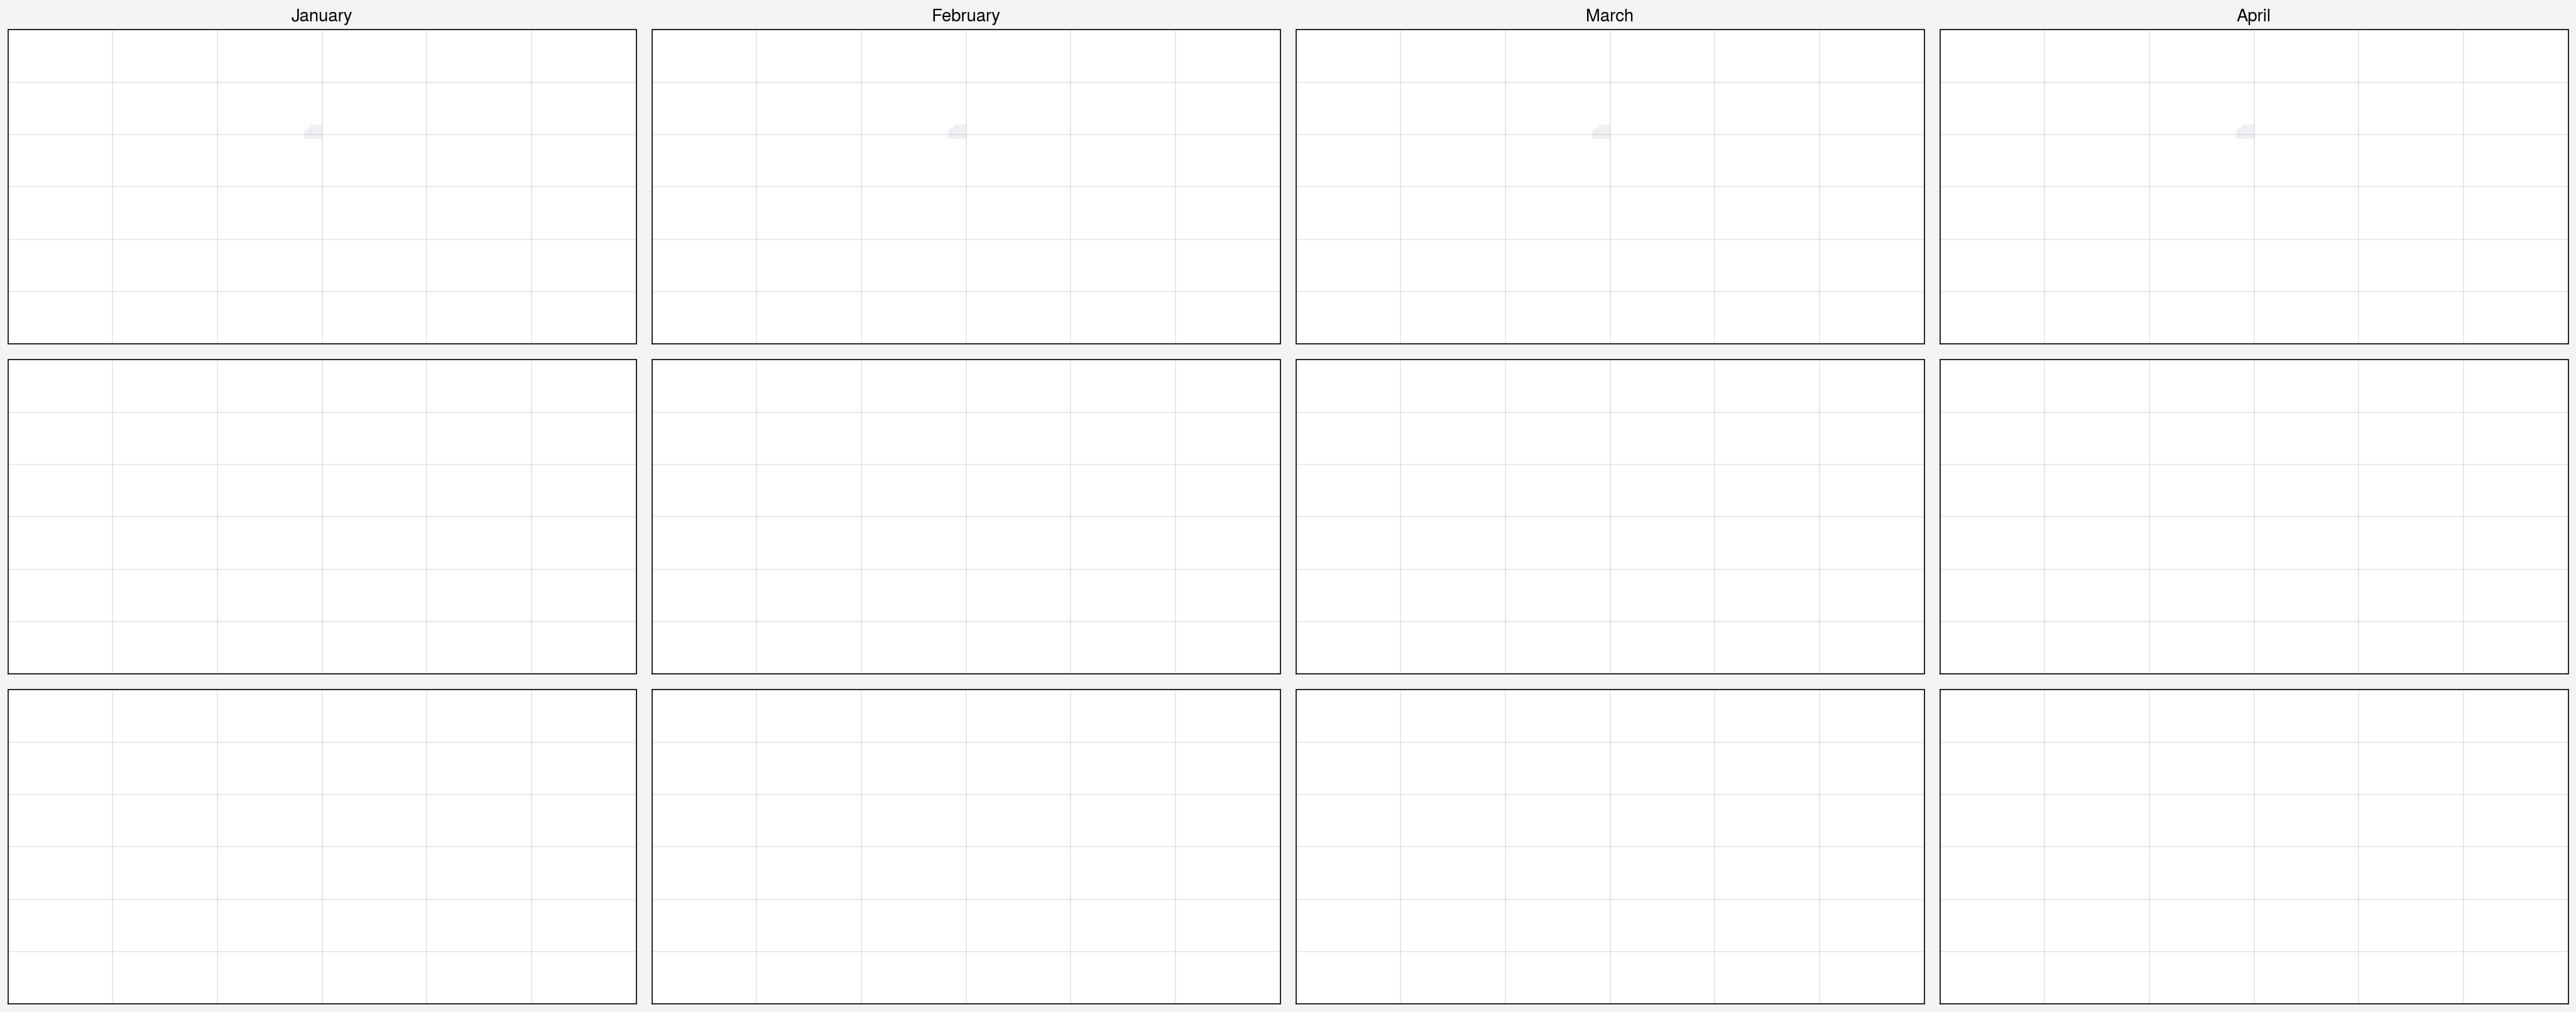

In [62]:
# Plote
# 1) # Masking significativity
signif=np.where(pvalue_scfv<0.05, True,False)

# Levels of scfv for the plot
levels=np.arange(-1,1,0.1)
factor=10 # degree per decade

title = {1: "January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"Jun", 7:"July",8:"August", 9:"September",10:"October",11:"November",12:"December"}   
# Producing the map of the trends, excluding the borders of the domain.
f, axs = plot.subplots(proj='cyl',ncols=4, nrows=3, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        scfv_atlas_filtred.lon,scfv_atlas_filtred.lat,
        slope_scfv[i,:,:]*factor,
        levels=levels,
        cmap='PuOr'  
    )
    ax.format(title=title[i+1])   # font.largesize=='20px'
    
    p = ax.contourf(
    scfv_atlas_filtred.lon,scfv_atlas_filtred.lat,
    signif[i,:,:],
    hatches=["", "//"], alpha=0
    )
    
f.colorbar(m, label= '%/decade')

axs.format(
    labels=True,
    coast=True, ocean=True, oceancolor='cyan', landcolor='bisque',borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()